In [3]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import pandas as pd 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        globals()[filename.split('.')[0]] = pd.read_csv(dirname+'/'+filename)
        print(filename)

customeraccount.csv
sample_submission.csv
transaction_header.csv
genel_kategoriler.csv
customer.csv
train.csv
test.csv
product_groups.csv
transaction_sale.csv


In [6]:
import numpy as np 

import optuna
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold, KFold,train_test_split
import datetime
from datetime import date
from collections import Counter
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,f1_score,mean_squared_error
from itertools import combinations
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline 
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor


pd.options.display.max_rows=250
pd.options.display.max_columns=250
pd.options.display.max_colwidth=25
cm = sns.light_palette("red", as_cmap=True)

def null_rate(df):
    return (df.isnull().sum()/df.shape[0]).to_frame().rename(columns={0:'null_rate'}).sort_values('null_rate',ascending=False).style.background_gradient(cmap=cm)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook
tqdm.pandas(desc="my bar!")




def calculate_optimum_threshold(y_true, y_pred_labels):
    max_thresh = 0.3
    max_score = 0
    for thresh in range(30, 60, 2):
        thresh = thresh / 100
        y_pred = (y_pred_labels > thresh).astype('int')
        score = f1_score(y_true, y_pred)
        if score >= max_score:
            max_score = score
            max_thresh = thresh
        if y_pred.sum()/y_pred.shape[0] < 0.005:
            continue
    print(f"Optimum threshold: {max_thresh}, Score: {max_score}")
    return max_thresh, max_score


def classification_scores(y_true, y_pred, threshold=0.5):

    """
    Calculate binary classification metrics on predicted probabilities and labels
    Parameters
    ----------
    y_true (numpy.ndarray of shape (n_samples)): Ground truth labels
    y_pred (numpy.ndarray of shape (n_samples)): Predicted probabilities
    threshold (float): Rounding threshold
    Returns
    -------
    scores (dict): Dictionary of calculated scores
    """

    y_pred_labels = round_probabilities(y_pred, threshold=threshold)
    scores = {
#         'accuracy': accuracy_score(y_true, y_pred_labels),
#         'roc_auc': roc_auc_score(y_true, y_pred),
#         'precision': precision_score(y_true, y_pred_labels),
#         'recall': recall_score(y_true, y_pred_labels),
        'f1': f1_score(y_true, y_pred_labels),
#         'pos_rate': f"{y_pred_labels.sum()}/{y_pred_labels.shape[0]}"
    }

    return scores

def round_probabilities(probabilities, threshold):

    """
    Round probabilities to labels based on the given threshold
    Parameters
    ----------
    probabilities (np.ndarray of shape (n_samples)): Predicted probabilities
    threshold (float): Rounding threshold
    Returns
    -------
    labels (numpy.ndarray of shape (n_samples)): Labels
    """

    labels = np.zeros_like(probabilities, dtype=np.uint8)
    labels[probabilities >= threshold] = 1

    return labels

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


# Data Preview

### 1-customerAccount

In [7]:
customeraccount=customeraccount.astype({'individualnumber':'object','cardnumber':'object'})
customeraccount.info()
# print(f'memory useage :',customeraccount.memory_usage().sum()/1024/1024,f'MB')
customeraccount.groupby('individualnumber')['cardnumber'].count().to_frame().sort_values('cardnumber',ascending=False)[:50].style.background_gradient(cmap=cm)

print(f'customeraccount null rate.')
null_rate(customeraccount)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35159 entries, 0 to 35158
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   individualnumber  35159 non-null  object
 1   cardnumber        35159 non-null  object
dtypes: object(2)
memory usage: 549.5+ KB


,cardnumber
individualnumber,
96035559,49
13936527,25
98338349,21
7923458,17
10817264,17
92455160,16
92472145,16
89086894,15
42273372,15


customeraccount null rate.


,null_rate
individualnumber,0.000000
cardnumber,0.000000


### 2-customer

In [8]:
customer=customer.astype({'individualnumber':'object','city_code':'object'})
customer.info()
null_rate(customer)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28593 entries, 0 to 28592
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  28593 non-null  object 
 1   gender            28588 non-null  object 
 2   city_code         21886 non-null  object 
 3   dateofbirth       28578 non-null  float64
dtypes: float64(1), object(3)
memory usage: 893.7+ KB


,null_rate
city_code,0.234568
dateofbirth,0.000525
gender,0.000175
individualnumber,0.000000


### 3-train

In [9]:
train=train.astype({'individualnumber':'object','category_number':'object','response':'float'})
train.info()
null_rate(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13115 entries, 0 to 13114
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13115 non-null  object 
 1   category_number   13115 non-null  object 
 2   hakkedis_amt      13115 non-null  float64
 3   odul_amt          13115 non-null  float64
 4   response          13115 non-null  float64
dtypes: float64(3), object(2)
memory usage: 512.4+ KB


,null_rate
individualnumber,0.000000
category_number,0.000000
hakkedis_amt,0.000000
odul_amt,0.000000
response,0.000000


### 3-test

In [10]:
test=test.astype({'individualnumber':'object','category_number':'object'})
test.info()
null_rate(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13236 entries, 0 to 13235
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13236 non-null  object 
 1   category_number   13236 non-null  object 
 2   hakkedis_amt      13236 non-null  float64
 3   odul_amt          13236 non-null  float64
dtypes: float64(2), object(2)
memory usage: 413.8+ KB


,null_rate
individualnumber,0.000000
category_number,0.000000
hakkedis_amt,0.000000
odul_amt,0.000000


### 4-product_groups

In [11]:
product_groups=product_groups.astype({'category_number':'object','category_level_1':'object','category_level_2':'object','category_level_3':'object','category_level_4':'object'})
product_groups.info()
null_rate(product_groups)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category_number   3913 non-null   object
 1   category_level_1  3913 non-null   object
 2   category_level_2  3913 non-null   object
 3   category_level_3  3913 non-null   object
 4   category_level_4  3913 non-null   object
dtypes: object(5)
memory usage: 153.0+ KB


,null_rate
category_number,0.000000
category_level_1,0.000000
category_level_2,0.000000
category_level_3,0.000000
category_level_4,0.000000


### 5-transaction_sale

In [12]:
transaction_sale=transaction_sale.astype({'basketid':'object','category_level_1':'object','category_level_2':'object','category_level_3':'object','category_level_4':'object'})

transaction_sale.info()

null_rate(transaction_sale)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537881 entries, 0 to 6537880
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   basketid          object 
 1   category_level_1  object 
 2   category_level_2  object 
 3   category_level_3  object 
 4   category_level_4  object 
 5   amount            float64
 6   quantity          float64
 7   discount_type_1   float64
 8   discount_type_2   float64
 9   discount_type_3   float64
dtypes: float64(5), object(5)
memory usage: 498.8+ MB


,null_rate
discount_type_1,0.711067
discount_type_2,0.000020
discount_type_3,0.000020
basketid,0.000000
category_level_1,0.000000
category_level_2,0.000000
category_level_3,0.000000
category_level_4,0.000000
amount,0.000000
quantity,0.000000


### 6-transaction_header

In [13]:
transaction_header=transaction_header.astype({'date_of_transaction':'datetime64','cardnumber':'object','basketid':'object','is_sanal':'object'})
transaction_header.info()
null_rate(transaction_header)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124673 entries, 0 to 1124672
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_of_transaction  1124673 non-null  datetime64[ns]
 1   cardnumber           1124673 non-null  object        
 2   basketid             1124673 non-null  object        
 3   is_sanal             1124673 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 34.3+ MB


,null_rate
date_of_transaction,0.000000
cardnumber,0.000000
basketid,0.000000
is_sanal,0.000000


### genel_kategoriler

In [14]:
genel_kategoriler=genel_kategoriler.astype({'category_number':'object'})
genel_kategoriler.info()
null_rate(genel_kategoriler)
print(f'genel_kategoriler shape',genel_kategoriler.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category_number  50 non-null     object
 1   genel_kategori   50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes


,null_rate
category_number,0.000000
genel_kategori,0.000000


genel_kategoriler shape (50, 2)


## Some Data preprocessing stages

In [15]:
cinfo=customer.merge(customeraccount,on='individualnumber')
cinfo.loc[cinfo.city_code.isnull(),'city_code']='unknown'
cinfo.loc[cinfo.gender.isnull(),'gender']='E'
cinfo.loc[cinfo.dateofbirth.isnull(),'dateofbirth']=round(cinfo.dateofbirth.mean())
#-------------------
test=sample_submission.merge(test,how='left',on='individualnumber').drop('response',axis=1)
#-------------------
df_train_test=pd.concat([train,test],axis=0)
#-------------------
df_train_test['odul_amt_hakkedis_amt']=df_train_test.odul_amt/df_train_test.hakkedis_amt
dum=df_train_test.groupby('category_number').odul_amt_hakkedis_amt.mean().to_frame().rename(columns={'odul_amt_hakkedis_amt':'odul_amt_hakkedis_amt_gb'})
df_train_test=df_train_test.merge(dum,how='left',on='category_number')
transaction_header['month']=transaction_header.date_of_transaction.dt.month
transaction_header['year']=transaction_header.date_of_transaction.dt.year
transaction_header['day']=transaction_header.date_of_transaction.dt.day
transaction_header['day_of_weak']=transaction_header.date_of_transaction.dt.dayofweek
transaction_sale['amt_quantity_rate']=transaction_sale.amount/transaction_sale.quantity
transaction_sale['sum_discount_type']=transaction_sale[['discount_type_1','discount_type_2', 'discount_type_3']].sum(axis=1)
#----------------------------------------------------------------------
print(f'Train shape :',train.shape)
print(f'Test shape:',test.shape)


cinfo=cinfo[cinfo.individualnumber.isin(df_train_test.individualnumber)] # in here ,We are selecting only individualnumber of df_train_test inside from cinfo dataframe
cinfo=cinfo[cinfo.cardnumber.isin(transaction_header.cardnumber)]
df_train_test=df_train_test.merge(cinfo,on='individualnumber')
df_train_test.loc[df_train_test.hakkedis_amt>140,'hakkedis_amt']=140

# -----------------------------------------------------------------
transaction_header=transaction_header[transaction_header.cardnumber.isin(df_train_test.cardnumber)]
data=df_train_test.merge(transaction_header.merge(transaction_sale,on='basketid'),on='cardnumber')

Train shape : (13115, 5)
Test shape: (13236, 4)


In [16]:
df_train_test

,individualnumber,category_number,hakkedis_amt,odul_amt,response,odul_amt_hakkedis_amt,odul_amt_hakkedis_amt_gb,gender,city_code,dateofbirth,cardnumber
0,94230288,9000,21.0,2.0,0.0,0.095238,0.070656,E,7.0,1983.0,787714605562415
1,4684087,9000,17.0,1.0,0.0,0.058824,0.070656,E,19.0,1951.0,9087854623560519
2,92472145,9058,24.0,3.0,0.0,0.125000,0.090641,K,35.0,1982.0,7987144623566015
3,88026681,9030,22.0,2.0,0.0,0.090909,0.079497,K,unknown,1961.0,7087024687560515
4,98127795,9001,38.0,3.0,0.0,0.078947,0.083544,E,9.0,1984.0,9687474690567815
...,...,...,...,...,...,...,...,...,...,...,...
27428,93418529,9049,32.0,3.0,NaN,0.093750,0.094351,E,38.0,1979.0,887284617560415
27429,97397069,9018,20.0,2.0,NaN,0.100000,0.070262,E,9.0,1993.0,6487034685567815
27430,95212479,9046,85.0,8.0,NaN,0.094118,0.094598,E,unknown,1962.0,7287954643563815
27431,93406449,9032,39.0,3.0,NaN,0.076923,0.094221,E,78.0,1966.0,9487234673567915


In [17]:
genel_kategoriler.head()

,category_number,genel_kategori
0,9052,diger
1,9053,diger
2,9054,diger
3,9055,gida
4,9056,gida


In [18]:
transaction_header

,date_of_transaction,cardnumber,basketid,is_sanal,month,year,day,day_of_weak
0,2020-12-01,8487374630565615,20120163990041163,0,12,2020,1,1
1,2020-12-01,4287574603569015,20120163990016137,0,12,2020,1,1
3,2020-12-01,3787564693563915,20120163570105022,0,12,2020,1,1
4,2020-12-01,9087994683569715,20120162340016645,0,12,2020,1,1
5,2020-12-01,8687004643564415,20120165320027109,0,12,2020,1,1
...,...,...,...,...,...,...,...,...
1124666,2021-12-01,1487884691566715,21120111210046426,0,12,2021,1,2
1124668,2021-12-01,5187224618568515,21120111950019800,0,12,2021,1,2
1124669,2021-12-01,87714689568015,21120111830079927,0,12,2021,1,2
1124670,2021-12-01,3287454606560415,21120110690047978,0,12,2021,1,2


In [19]:
transaction_sale

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,amt_quantity_rate,sum_discount_type
0,20120706070177471,613,50,50,15,19.90,2.0,NaN,0.0,0.00,9.95,0.00
1,20120706070177471,425,30,12,10,3.50,1.0,NaN,0.0,0.00,3.50,0.00
2,20120706070177471,425,30,12,11,7.90,1.0,NaN,0.0,0.00,7.90,0.00
3,20122703940031323,103,25,15,10,7.90,2.0,NaN,0.0,0.00,3.95,0.00
4,20122703940031323,101,15,15,15,16.00,1.0,NaN,0.0,0.00,16.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
6537876,20120839080026509,103,35,10,10,2.95,1.0,NaN,0.0,0.00,2.95,0.00
6537877,20120839080026509,130,85,11,10,3.40,1.0,NaN,0.0,0.00,3.40,0.00
6537878,20120839080026509,131,10,10,20,4.45,1.0,NaN,0.0,0.00,4.45,0.00
6537879,21101831040099839,103,35,10,10,0.01,1.0,NaN,0.0,1.24,0.01,1.24


In [20]:
transaction_sale[['discount_type_1','discount_type_2','discount_type_3']].replace(0,1)

,discount_type_1,discount_type_2,discount_type_3
0,NaN,1.0,1.00
1,NaN,1.0,1.00
2,NaN,1.0,1.00
3,NaN,1.0,1.00
4,NaN,1.0,1.00
...,...,...,...
6537876,NaN,1.0,1.00
6537877,NaN,1.0,1.00
6537878,NaN,1.0,1.00
6537879,NaN,1.0,1.24


In [21]:
from sklearn.cluster import KMeans
dum_df=transaction_sale[['category_level_1','category_level_2','category_level_3','category_level_4']]
dum_df=dum_df.astype({'category_level_1':str,'category_level_2':str,'category_level_3':str,'category_level_4':str})
kmeans = KMeans(n_clusters=20, random_state=0).fit(dum_df)
gc.collect()
transaction_sale['category_labels']=kmeans.labels_

168

In [22]:
transaction_sale['discount_mul']=transaction_sale.discount_type_1.replace(0,1).fillna(1).mul(transaction_sale.discount_type_2.replace(0,1).fillna(1)).mul(transaction_sale.discount_type_3.replace(0,1).fillna(1))

In [23]:
transaction_header=transaction_header[transaction_header.cardnumber.isin(df_train_test.cardnumber)]
data=df_train_test.merge(transaction_header.merge(transaction_sale,on='basketid'),on='cardnumber')  #transaction_sale and transaction_Header merged over baskedid  then merged df_train_test over cardnumber
data=data.merge(genel_kategoriler,on='category_number')
data=pd.concat([data,pd.get_dummies(data.genel_kategori)],axis=1)
data=pd.concat([data,pd.get_dummies(data.category_labels)],axis=1)

gc.collect()

0

In [24]:
# dum=data2[data2.response.notnull()].groupby(['category_level_1','category_level_2']).discount_type_1.mean().to_frame()
# data2.loc[data2.discount_type_1.isnull(),'discount_type_1']=data2[data2.discount_type_1.isnull()].drop('discount_type_1',axis=1).merge(dum.reset_index(),on=['category_level_1','category_level_2']).discount_type_1.values

# dum=data2[data2.response.notnull()].groupby(['genel_kategori','category_number']).discount_type_2.mean().to_frame()
# data2.loc[data2.discount_type_2.isnull(),'discount_type_2']=data2[data2.discount_type_2.isnull()].drop('discount_type_2',axis=1).merge(dum.reset_index(),on=['genel_kategori','category_number']).discount_type_2.values

# dum=data2[data2.response.notnull()].groupby(['genel_kategori','category_number']).discount_type_3.mean().to_frame()
# data2.loc[data2.discount_type_3.isnull(),'discount_type_3']=data2[data2.discount_type_3.isnull()].drop('discount_type_3',axis=1).merge(dum.reset_index(),on=['genel_kategori','category_number']).discount_type_3.values


In [25]:
# data2.discount_type_1.fillna(0,inplace=True)
# data2.discount_type_2.fillna(0,inplace=True)
# data2.discount_type_3.fillna(0,inplace=True)

In [26]:
data2_1=data.groupby('individualnumber').agg(
gender=('gender','first'),
city_code=('city_code','first'),
dateofbirth=('dateofbirth','first'),
    
sum_amount=('amount','sum'),  
mean_amount=('amount','mean'),
quantity_sum=('quantity','mean'),
diger_amount=('diger','sum'),    
gida_amount=('gida','sum'),    
hijyen_amount=('hijyen','sum'),
icecek_amount=('icecek','sum'),    
kisisel_bakim_amount=('kisisel_bakim','sum'),    
is_sanal_sayısı=('is_sanal','count'), 
basket_sayısı=('basketid','count'), 
discount_type_1_toplam=('discount_type_1','sum'), 
discount_type_2_toplam=('discount_type_2','sum'), 
discount_type_3_toplam=('discount_type_3','sum'),
day_of_weak_freq=('day_of_weak',lambda x:x.value_counts().index[0]),
day_freq=('day',lambda x:x.value_counts().index[0]),
month_freq=('month',lambda x:x.value_counts().index[0]),
date_diff=('date_of_transaction',lambda x:(x.max()-x.min()).days),
hakkedis_amt=('hakkedis_amt','first'), 
response=('response','first'), 
odul_amt_hakkedis_amt=('odul_amt_hakkedis_amt','first'), 
odul_amt=('odul_amt','count'), 
odul_amt_hakkedis_amt_gb=('odul_amt_hakkedis_amt_gb','first'), 
category_number=('category_number','first'),
sum_discount_type=('sum_discount_type','sum'),
sum_discount_mul=('discount_mul','sum'),

# response12=('response12','sum'),
# response23=('response23','sum'),
# response34=('response34','sum'),
# response14=('response14','sum'), 
# response123=('response123','sum'),
# response134=('response134','sum'),
# response124=('response124','sum')
    
L_0=(0,'sum'),         
L_1=(1,'sum') ,    
L_2=(2,'sum')  ,
L_3=(3,'sum')  ,
L_4=(4,'sum')   ,
L_5=(5,'sum')  ,
L_6=(6,'sum')  ,
L_7=(7,'sum')  ,
L_8=(8,'sum')  ,
L_9=(9,'sum')  ,
L_10=(10,'sum') , 
L_11=(11,'sum')  ,
L_12=(12,'sum')  ,     
L_13=(13,'sum')  ,
L_14=(14,'sum')  ,
L_15=(15,'sum')  ,
L_16=(16,'sum')  ,
L_17=(17,'sum')  ,
L_18=(18,'sum')  ,
L_19=(19,'sum') ,  
    

).reset_index()

data2_1   

,individualnumber,gender,city_code,dateofbirth,sum_amount,mean_amount,quantity_sum,diger_amount,gida_amount,hijyen_amount,icecek_amount,kisisel_bakim_amount,is_sanal_sayısı,basket_sayısı,discount_type_1_toplam,discount_type_2_toplam,discount_type_3_toplam,day_of_weak_freq,day_freq,month_freq,date_diff,hakkedis_amt,response,odul_amt_hakkedis_amt,odul_amt,odul_amt_hakkedis_amt_gb,category_number,sum_discount_type,sum_discount_mul,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9,L_10,L_11,L_12,L_13,L_14,L_15,L_16,L_17,L_18,L_19
0,356411,K,9.0,1972.0,7131.68,16.859764,1.552830,0.0,423.0,0.0,0.0,0.0,423,423,189.939580,120.22,473.40,5,8,12,359,56.0,NaN,0.089286,423,0.094598,9046,783.559580,1623.380326,24.0,11.0,19.0,45.0,3.0,25.0,14.0,0,101.0,48.0,12.0,33.0,24.0,0,18.0,1.0,0,4,9.0,32.0
1,375612,E,34.0,1952.0,61828.69,47.487473,1.880174,0.0,0.0,1302.0,0.0,0.0,1302,1302,201.919945,1758.50,2524.94,0,27,8,364,43.0,NaN,0.139535,1302,0.096982,9022,4485.359945,5389.121175,86.0,2.0,111.0,38.0,9.0,45.0,10.0,85,246.0,65.0,223.0,27.0,231.0,0,1.0,78.0,0,23,12.0,10.0
2,393158,E,26.0,1973.0,3792.19,22.047616,2.640017,0.0,172.0,0.0,0.0,0.0,172,172,363.152444,263.23,300.27,4,17,6,362,7.0,NaN,0.142857,172,0.117774,9003,926.652444,2287.884853,9.0,1.0,8.0,3.0,10.0,3.0,8.0,0,18.0,22.0,3.0,29.0,9.0,0,21.0,6.0,3,2,2.0,15.0
3,452480,K,6.0,1946.0,8514.57,13.200884,1.157322,0.0,0.0,645.0,0.0,0.0,645,645,200.276362,191.73,400.18,0,4,6,356,43.0,0.0,0.139535,645,0.096982,9022,792.186362,1616.753783,74.0,15.0,104.0,8.0,5.0,8.0,38.0,0,51.0,29.0,15.0,187.0,49.0,1,4.0,8.0,5,18,13.0,13.0
4,643968,K,34.0,1946.0,6049.92,15.200804,0.968535,0.0,398.0,0.0,0.0,0.0,398,398,306.889998,197.60,198.07,4,11,12,360,15.0,NaN,0.066667,398,0.073560,9017,702.559998,1132.618837,13.0,15.0,29.0,16.0,3.0,3.0,1.0,0,7.0,9.0,78.0,167.0,8.0,0,4.0,8.0,0,22,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26331,102278919,K,unknown,1996.0,147.64,16.404444,1.555556,0.0,9.0,0.0,0.0,0.0,9,9,0.000000,10.00,2.06,5,27,11,0,10.0,0.0,0.100000,9,0.073560,9017,12.060000,19.060000,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,0.0,2.0,0.0,0.0,1.0,0,0.0,0.0,0,0,0.0,2.0
26332,102279267,K,unknown,1991.0,97.30,9.730000,1.000000,0.0,10.0,0.0,0.0,0.0,10,10,0.000000,0.00,0.00,0,29,11,0,10.0,0.0,0.100000,10,0.073560,9017,0.000000,10.000000,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,2.0,2.0,0.0,0,0.0,0.0,0,0,0.0,1.0
26333,102280492,K,34.0,1986.0,73.35,10.478571,1.000000,0.0,7.0,0.0,0.0,0.0,7,7,0.000000,10.00,10.00,0,29,11,0,10.0,NaN,0.100000,7,0.073560,9017,20.000000,106.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0,0,0.0,2.0
26334,102280832,K,1.0,1983.0,54.35,13.587500,1.500000,0.0,4.0,0.0,0.0,0.0,4,4,0.000000,1.50,6.90,6,7,11,4,10.0,0.0,0.100000,4,0.073560,9017,8.400000,10.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0,0,0.0,1.0


In [27]:
# data2=pd.merge(data2_1,data2,on='individualnumber')

In [28]:
data_end=data2_1.copy()
# data_end['yas']=data_end.dateofbirth.map(lambda x: 2022-float(str(x)))
# lbls=['0-18', '18-25', '25-35', '35-40', '40-50', '50-100']
# bins=[0,18, 25, 35, 40, 50,100]
# data_end['yas_label']=pd.cut(data_end.yas,bins=bins, labels=lbls,ordered=False,right=False) 
# --------------------------------
data_end=data_end.astype({'day_of_weak_freq':str,
                 'day_freq':str,
                 'month_freq':str,
                 'category_number':str,
                 'gender':str,
#                  'yas_label':str,
                 'city_code':str})

cat_features=['day_of_weak_freq', 'gender','city_code','day_freq',
#               'yas_label',
              'month_freq','category_number']
data_end['günlük_ort_harcama']=data_end.date_diff/data_end.sum_amount
print(f'data_end shape',data_end.shape)

# -----------------------------
Le=LabelEncoder()
data_end.loc[:,cat_features]=data_end[cat_features].apply(lambda x: Le.fit_transform(x),axis=0)
# ------------------------------------------------------------------------------------------------------------
data_train=data_end[data_end.response.notnull()].drop('response',axis=1)
target_train=data_end[data_end.response.notnull()].response
data_test=data_end[data_end.response.isnull()].drop('response',axis=1)
test_id=data_test.individualnumber
data_test.drop(['individualnumber'],axis=1,inplace=True)
train_id=data_train.individualnumber
data_train.drop(['individualnumber'],axis=1,inplace=True)
print(f'data_train shape',data_train.shape)
print(f'data_test shape',data_test.shape)

data_end shape (26336, 50)
data_train shape (13111, 48)
data_test shape (13225, 48)


In [29]:
data_end.loc[:,cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26336 entries, 0 to 26335
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   day_of_weak_freq  26336 non-null  int64
 1   gender            26336 non-null  int64
 2   city_code         26336 non-null  int64
 3   day_freq          26336 non-null  int64
 4   month_freq        26336 non-null  int64
 5   category_number   26336 non-null  int64
dtypes: int64(6)
memory usage: 1.2 MB


In [30]:
# param={
# 'lambda': 2.465963549393914, 'alpha': 9.91601759481999, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 22, 'scale_pos_weight': 12.816243563454234,
#     'n_estimators': 5000,
#     'use_label_encoder':False,            
#     'eval_metric':'logloss',
#     "objective": "binary:logistic",
# #     'scale_pos_weight':70,
#     'tree_method':'gpu_hist',
# #     'early_stopping_rounds':100
# } 
# score_list1=[]
# kf = KFold(n_splits=3, shuffle=True, random_state = 34)
# folds=list(kf.split(data_train,target_train))
# train_losses=[]
# val_losses=[]
# thresholds=[]
# for train_index, test_index in folds:
#     X_train , X_val = data_train.iloc[train_index], data_train.iloc[test_index]  
#     y_train, y_val = target_train.iloc[train_index], target_train.iloc[test_index]  
#     val_set=[(X_train,y_train),(X_val, y_val)]

#     model = xgb.XGBClassifier(**param)  
#     model.fit(X_train,y_train, eval_set=val_set,verbose=False )
#     results = model.evals_result()
# #         val_pred=(np.where(model.predict(X_val) >= 0.5, 1, 0))
# #         f1score=f1_score(val_pred,y_val)     
    
#     preds = model.predict_proba(X_val)[:, 1]
#     threshold, val_score = calculate_optimum_threshold(y_val, preds)
    
#     f1score = classification_scores(y_val, preds, threshold=threshold)
# #     f1score=f1_score(val_scores,y_val)

# #         f1score=f1_score(val_pred,y_val)
#     score_list1.append( list(f1score.values())[0])
#     train_losses.append(results['validation_0']['logloss'])
#     val_losses.append(results['validation_1']['logloss'])
#     thresholds.append(threshold)
# print(np.mean(thresholds))
# train_loses=np.mean(train_losses,axis=0)
# val_loses=np.mean(val_losses,axis=0)

In [31]:
# # retrieve performance metrics
# results = model.evals_result()
# epochs = len(results['validation_0']['logloss'])
# x_axis = range(0, epochs)
# # plot log loss
# fig, ax = plt.subplots(figsize=(15, 10))
# ax.plot(x_axis, train_loses, label='Train');
# ax.plot(x_axis, val_loses, label='Validation');
# ax.legend();
# plt.ylabel('Log Loss');
# plt.title('XGBoost Log Loss');
# plt.xlabel('epocs');
# plt.show();

In [33]:
from sklearn import metrics
def objective(trial,data=data_train,target=target_train
        ):
    
    param = {'use_label_encoder':False,            
              'eval_metric':'logloss',
             "objective": "binary:logistic",
            'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
             'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
             'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
             'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.1,0.2,0.5]),
             'n_estimators': 300,
             'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
             'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.0, 100.0),

#                'scale_pos_weight':60,
#              'early_stopping_rounds':100

    }
    
    score_list1=[]
    kf = KFold(n_splits=3, shuffle=True)
    folds=list(kf.split(data_train,target_train))
    thresholds=[]
    for train_index, test_index in folds:
        X_train , X_val = data_train.iloc[train_index], data_train.iloc[test_index]  
        y_train, y_val = target_train.iloc[train_index], target_train.iloc[test_index]  
        val_set=[(X_val, y_val)]

        model = xgb.XGBClassifier(**param)  
        model.fit(X_train,y_train, eval_set=val_set,verbose=0)
    #         val_pred=(np.where(model.predict(X_val) >= 0.5, 1, 0))
    #         f1score=f1_score(val_pred,y_val)     

        preds = model.predict_proba(X_val)[:, 1]
        threshold, val_score = calculate_optimum_threshold(y_val, preds)
        f1score = classification_scores(y_val, preds, threshold=threshold)
    #     f1score=f1_score(val_scores,y_val)

    #         f1score=f1_score(val_pred,y_val)
        score_list1.append( list(f1score.values())[0])
        thresholds.append(threshold)
    score=np.mean(score_list1)
    print(f"treshold mean : {np.mean(thresholds)}")
    print('-----------------------')
    print('-----------------------')
    return score
    


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=255)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
gc.collect()

[I 2022-12-30 19:12:13,204] A new study created in memory with name: no-name-d7f2aeea-b271-4ee1-8d12-108bb7cd4962


Optimum threshold: 0.58, Score: 0.3288590604026846
Optimum threshold: 0.58, Score: 0.24783861671469742


[I 2022-12-30 19:12:16,151] Trial 0 finished with value: 0.27831864512521337 and parameters: {'lambda': 9.906937572341501, 'alpha': 5.475384124832913, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 267, 'scale_pos_weight': 33.66358323314353}. Best is trial 0 with value: 0.27831864512521337.


Optimum threshold: 0.58, Score: 0.25825825825825827
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.27924528301886786
Optimum threshold: 0.58, Score: 0.2934362934362934


[I 2022-12-30 19:12:26,467] Trial 1 finished with value: 0.2964279643524926 and parameters: {'lambda': 7.33381454020192, 'alpha': 2.695409143925413, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 295, 'scale_pos_weight': 16.220214028319823}. Best is trial 1 with value: 0.2964279643524926.


Optimum threshold: 0.58, Score: 0.3166023166023166
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.34848484848484845
Optimum threshold: 0.58, Score: 0.35242290748898675


[I 2022-12-30 19:12:28,976] Trial 2 finished with value: 0.3447470297690562 and parameters: {'lambda': 4.16133926054021, 'alpha': 4.712844363245498, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 111, 'scale_pos_weight': 74.5190480034758}. Best is trial 2 with value: 0.3447470297690562.


Optimum threshold: 0.58, Score: 0.3333333333333333
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.20458553791887124
Optimum threshold: 0.58, Score: 0.150087260034904


[I 2022-12-30 19:12:30,838] Trial 3 finished with value: 0.1829975594574368 and parameters: {'lambda': 9.07773687018969, 'alpha': 1.2411833135431214, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 269, 'scale_pos_weight': 99.71330344443926}. Best is trial 2 with value: 0.3447470297690562.


Optimum threshold: 0.58, Score: 0.19431988041853512
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.38095238095238093
Optimum threshold: 0.56, Score: 0.3473684210526316


[I 2022-12-30 19:12:40,968] Trial 4 finished with value: 0.3511479849047907 and parameters: {'lambda': 6.583562757657662, 'alpha': 7.024192514366274, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 116, 'scale_pos_weight': 17.58852922488728}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.56, Score: 0.3251231527093596
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39405204460966536
Optimum threshold: 0.58, Score: 0.3206751054852321


[I 2022-12-30 19:12:53,630] Trial 5 finished with value: 0.34152876834149165 and parameters: {'lambda': 4.6989087356315835, 'alpha': 2.759540908176465, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 30, 'scale_pos_weight': 68.8056600322419}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.30985915492957744
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.33210332103321033
Optimum threshold: 0.58, Score: 0.3615384615384616


[I 2022-12-30 19:13:04,603] Trial 6 finished with value: 0.3384936210104807 and parameters: {'lambda': 9.400338363196765, 'alpha': 2.7759360030490496, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 96, 'scale_pos_weight': 23.24949836440011}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.3218390804597701
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.228287841191067
Optimum threshold: 0.58, Score: 0.2712765957446808


[I 2022-12-30 19:13:06,682] Trial 7 finished with value: 0.26063912603740613 and parameters: {'lambda': 6.462982142434667, 'alpha': 5.344834747943571, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 178, 'scale_pos_weight': 38.67711363966574}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.2823529411764706
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3232323232323232
Optimum threshold: 0.58, Score: 0.32967032967032966


[I 2022-12-30 19:13:08,935] Trial 8 finished with value: 0.3217316705688799 and parameters: {'lambda': 0.49587412389287133, 'alpha': 2.5065082869910187, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 151, 'scale_pos_weight': 27.25946840211237}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.3122923588039867
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.25069637883008355
Optimum threshold: 0.58, Score: 0.29651162790697677


[I 2022-12-30 19:13:10,646] Trial 9 finished with value: 0.28538369872265157 and parameters: {'lambda': 7.805020296640304, 'alpha': 9.896102942862717, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 148, 'scale_pos_weight': 39.3290404839915}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.56, Score: 0.3089430894308943
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.33142857142857146
Optimum threshold: 0.32, Score: 0.36986301369863006


[I 2022-12-30 19:13:12,493] Trial 10 finished with value: 0.31909719504240047 and parameters: {'lambda': 2.6878054283135353, 'alpha': 8.661272726068816, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 4, 'scale_pos_weight': 5.764874355740673}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.36, Score: 0.256
treshold mean : 0.3333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.29553264604810997
Optimum threshold: 0.54, Score: 0.30030030030030036


[I 2022-12-30 19:13:15,890] Trial 11 finished with value: 0.2990383325434872 and parameters: {'lambda': 4.543070131060638, 'alpha': 7.454751062267276, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 77, 'scale_pos_weight': 62.877178780778195}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.3012820512820513
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3161094224924012
Optimum threshold: 0.58, Score: 0.2920634920634921


[I 2022-12-30 19:13:18,807] Trial 12 finished with value: 0.29073928612537264 and parameters: {'lambda': 3.0127203766494004, 'alpha': 6.493433182376353, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 100, 'scale_pos_weight': 85.20182051781507}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.26404494382022475
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.25806451612903225
Optimum threshold: 0.58, Score: 0.2992125984251969


[I 2022-12-30 19:13:20,483] Trial 13 finished with value: 0.27256459374029857 and parameters: {'lambda': 5.30941246988458, 'alpha': 4.498570739985035, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 212, 'scale_pos_weight': 60.3518240067693}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.2604166666666667
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2663043478260869
Optimum threshold: 0.58, Score: 0.2647887323943662


[I 2022-12-30 19:13:23,271] Trial 14 finished with value: 0.2759321256412499 and parameters: {'lambda': 6.034875416238792, 'alpha': 7.416278105697661, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 64, 'scale_pos_weight': 80.34111316818075}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.2967032967032967
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.29333333333333333
Optimum threshold: 0.58, Score: 0.358974358974359


[I 2022-12-30 19:13:26,004] Trial 15 finished with value: 0.3220587684821261 and parameters: {'lambda': 3.2189663962074833, 'alpha': 4.322814394328104, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.5, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 121, 'scale_pos_weight': 49.20011545937866}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.5, Score: 0.31386861313868614
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-30 19:13:27,522] Trial 16 finished with value: 0.0 and parameters: {'lambda': 0.8906082392199357, 'alpha': 0.054673337615085416, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 200, 'scale_pos_weight': 2.2005818963698704}. Best is trial 4 with value: 0.3511479849047907.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4320987654320988
Optimum threshold: 0.54, Score: 0.38961038961038963


[I 2022-12-30 19:13:29,262] Trial 17 finished with value: 0.40949627201981253 and parameters: {'lambda': 1.9894034171868573, 'alpha': 6.555684159308623, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 43, 'scale_pos_weight': 51.45366407032634}. Best is trial 17 with value: 0.40949627201981253.


Optimum threshold: 0.58, Score: 0.4067796610169492
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.441860465116279
Optimum threshold: 0.32, Score: 0.3366336633663366


[I 2022-12-30 19:13:31,490] Trial 18 finished with value: 0.3713548660937578 and parameters: {'lambda': 1.5201945001373272, 'alpha': 7.086557877951937, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 42, 'scale_pos_weight': 50.80366991369457}. Best is trial 17 with value: 0.40949627201981253.


Optimum threshold: 0.56, Score: 0.33557046979865773
treshold mean : 0.46
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.38202247191011235
Optimum threshold: 0.58, Score: 0.32167832167832167


[I 2022-12-30 19:13:33,184] Trial 19 finished with value: 0.3905123502994585 and parameters: {'lambda': 1.8316358334894096, 'alpha': 8.115822637206389, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 41, 'scale_pos_weight': 52.27597520326038}. Best is trial 17 with value: 0.40949627201981253.


Optimum threshold: 0.58, Score: 0.4678362573099415
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.38372093023255816
Optimum threshold: 0.32, Score: 0.36036036036036034


[I 2022-12-30 19:13:34,859] Trial 20 finished with value: 0.4095177800941198 and parameters: {'lambda': 1.7845962634526298, 'alpha': 8.998884605698125, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 46.889882655082104}. Best is trial 20 with value: 0.4095177800941198.


Optimum threshold: 0.42, Score: 0.48447204968944096
treshold mean : 0.39999999999999997
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4216867469879518
Optimum threshold: 0.54, Score: 0.4615384615384615


[I 2022-12-30 19:13:36,684] Trial 21 finished with value: 0.40263351106724593 and parameters: {'lambda': 1.8368379189788517, 'alpha': 8.795066033917744, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 49.120221120047106}. Best is trial 20 with value: 0.4095177800941198.


Optimum threshold: 0.36, Score: 0.3246753246753247
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4318181818181818
Optimum threshold: 0.5, Score: 0.42105263157894735


[I 2022-12-30 19:13:38,428] Trial 22 finished with value: 0.40883239567450097 and parameters: {'lambda': 0.1586517005743271, 'alpha': 9.894570205720061, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 46.69714291197027}. Best is trial 20 with value: 0.4095177800941198.


Optimum threshold: 0.3, Score: 0.3736263736263737
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.3404255319148936
Optimum threshold: 0.42, Score: 0.39751552795031053


[I 2022-12-30 19:13:40,142] Trial 23 finished with value: 0.38434513316261515 and parameters: {'lambda': 0.21352290267715412, 'alpha': 9.899613811870752, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 41.41719326986316}. Best is trial 20 with value: 0.4095177800941198.


Optimum threshold: 0.4, Score: 0.41509433962264153
treshold mean : 0.37333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.31046931407942235
Optimum threshold: 0.58, Score: 0.3561643835616438


[I 2022-12-30 19:13:43,662] Trial 24 finished with value: 0.3315008500333609 and parameters: {'lambda': 1.2678818013986057, 'alpha': 8.968508300217481, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 63, 'scale_pos_weight': 59.85699598284613}. Best is trial 20 with value: 0.4095177800941198.


Optimum threshold: 0.58, Score: 0.3278688524590164
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.441025641025641
Optimum threshold: 0.58, Score: 0.4321608040201005


[I 2022-12-30 19:13:47,808] Trial 25 finished with value: 0.4075670027175125 and parameters: {'lambda': 2.386215462782584, 'alpha': 6.026151928482062, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 30, 'scale_pos_weight': 32.043407610801836}. Best is trial 20 with value: 0.4095177800941198.


Optimum threshold: 0.58, Score: 0.34951456310679613
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.32116788321167883
Optimum threshold: 0.56, Score: 0.31475409836065577


[I 2022-12-30 19:13:50,340] Trial 26 finished with value: 0.32186410374755475 and parameters: {'lambda': 0.11640817020469932, 'alpha': 9.201977532936992, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 54, 'scale_pos_weight': 42.04335491959133}. Best is trial 20 with value: 0.4095177800941198.


Optimum threshold: 0.56, Score: 0.32967032967032966
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.45714285714285713
Optimum threshold: 0.56, Score: 0.4696969696969697


[I 2022-12-30 19:13:52,302] Trial 27 finished with value: 0.43669111992465287 and parameters: {'lambda': 3.472867269140705, 'alpha': 8.09619757805246, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 55.82173991049806}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.42, Score: 0.3832335329341318
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.29166666666666663
Optimum threshold: 0.56, Score: 0.3547169811320755


[I 2022-12-30 19:13:53,963] Trial 28 finished with value: 0.3279787968049253 and parameters: {'lambda': 3.693461464273201, 'alpha': 8.298147385709168, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 80, 'scale_pos_weight': 65.28045414231548}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.58, Score: 0.33755274261603374
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.3666666666666667
Optimum threshold: 0.42, Score: 0.42944785276073616


[I 2022-12-30 19:13:56,117] Trial 29 finished with value: 0.41823774851401746 and parameters: {'lambda': 3.6543699231412896, 'alpha': 5.973062845406853, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 56.23257871167915}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.46, Score: 0.45859872611464964
treshold mean : 0.39999999999999997
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.38823529411764707
Optimum threshold: 0.56, Score: 0.37086092715231783


[I 2022-12-30 19:13:58,265] Trial 30 finished with value: 0.397959609988539 and parameters: {'lambda': 3.662584750517408, 'alpha': 3.7904409134770005, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 30, 'scale_pos_weight': 57.4626339697668}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.58, Score: 0.43478260869565216
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3563218390804598
Optimum threshold: 0.54, Score: 0.3459459459459459


[I 2022-12-30 19:14:00,251] Trial 31 finished with value: 0.36981780458964025 and parameters: {'lambda': 2.6057403830263572, 'alpha': 6.007155344471386, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 19, 'scale_pos_weight': 71.4058681821732}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.58, Score: 0.407185628742515
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.39344262295081966
Optimum threshold: 0.54, Score: 0.3977900552486188


[I 2022-12-30 19:14:02,460] Trial 32 finished with value: 0.3790595413817948 and parameters: {'lambda': 2.0638497677588266, 'alpha': 6.426907980705797, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 53, 'scale_pos_weight': 56.87192895037715}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.58, Score: 0.34594594594594597
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.40476190476190477
Optimum threshold: 0.52, Score: 0.4049079754601227


[I 2022-12-30 19:14:05,633] Trial 33 finished with value: 0.40322329340734253 and parameters: {'lambda': 3.8283639486939895, 'alpha': 8.007927538716547, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 26, 'scale_pos_weight': 32.33160976528358}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.38, Score: 0.4
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2593516209476309
Optimum threshold: 0.58, Score: 0.27173913043478265


[I 2022-12-30 19:14:08,068] Trial 34 finished with value: 0.26225752318807727 and parameters: {'lambda': 5.320100351418997, 'alpha': 5.456264467185709, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 80, 'scale_pos_weight': 74.90181384875794}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.58, Score: 0.2556818181818182
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.41777777777777775
Optimum threshold: 0.56, Score: 0.3235294117647059


[I 2022-12-30 19:14:11,540] Trial 35 finished with value: 0.35873030349090546 and parameters: {'lambda': 3.255869614347831, 'alpha': 7.711351016251997, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 37, 'scale_pos_weight': 55.375810463642345}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.58, Score: 0.33488372093023255
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2635294117647059
Optimum threshold: 0.56, Score: 0.22587268993839837


[I 2022-12-30 19:14:13,109] Trial 36 finished with value: 0.24327043628807654 and parameters: {'lambda': 1.0066106898267109, 'alpha': 6.913765380809314, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 300, 'scale_pos_weight': 45.73442922099502}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.58, Score: 0.24040920716112535
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.30025445292620867
Optimum threshold: 0.58, Score: 0.26006191950464397


[I 2022-12-30 19:14:14,608] Trial 37 finished with value: 0.266500707688995 and parameters: {'lambda': 4.283782120121057, 'alpha': 9.311319115655477, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 253, 'scale_pos_weight': 94.76286451097513}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.58, Score: 0.23918575063613232
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.32067510548523204
Optimum threshold: 0.56, Score: 0.4257028112449799


[I 2022-12-30 19:14:18,529] Trial 38 finished with value: 0.36394415406158576 and parameters: {'lambda': 2.1473304390309584, 'alpha': 6.454992236231204, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 66.83302213433026}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.54, Score: 0.34545454545454546
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.33136094674556216
Optimum threshold: 0.58, Score: 0.430939226519337


[I 2022-12-30 19:14:29,485] Trial 39 finished with value: 0.39652430017920876 and parameters: {'lambda': 2.9320640097343422, 'alpha': 5.033210013002298, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 51, 'scale_pos_weight': 35.47977495561231}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.54, Score: 0.42727272727272725
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.38947368421052636
Optimum threshold: 0.58, Score: 0.3803680981595092


[I 2022-12-30 19:14:35,415] Trial 40 finished with value: 0.40404982489257596 and parameters: {'lambda': 3.8813086038278106, 'alpha': 5.884061298293825, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 17, 'scale_pos_weight': 25.891721602279198}. Best is trial 27 with value: 0.43669111992465287.


Optimum threshold: 0.56, Score: 0.44230769230769235
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4671532846715329
Optimum threshold: 0.58, Score: 0.4264705882352941


[I 2022-12-30 19:14:37,245] Trial 41 finished with value: 0.44454129096894235 and parameters: {'lambda': 1.4631609602323254, 'alpha': 9.761814989913685, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 47.298699035194005}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.44
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.36
Optimum threshold: 0.42, Score: 0.4530386740331492


[I 2022-12-30 19:14:38,895] Trial 42 finished with value: 0.3965540168855086 and parameters: {'lambda': 0.7917230613200136, 'alpha': 8.542719972444022, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 53.40157329425554}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.37662337662337664
treshold mean : 0.4533333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.42105263157894735
Optimum threshold: 0.58, Score: 0.3627906976744186


[I 2022-12-30 19:14:46,382] Trial 43 finished with value: 0.3785650603684059 and parameters: {'lambda': 1.5332644104750572, 'alpha': 9.305205711164449, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 5, 'scale_pos_weight': 43.85899084411933}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3518518518518518
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.29441624365482233
Optimum threshold: 0.58, Score: 0.30337078651685395


[I 2022-12-30 19:14:48,078] Trial 44 finished with value: 0.31490860189396014 and parameters: {'lambda': 4.802172772907938, 'alpha': 7.792916930402774, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.5, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 41, 'scale_pos_weight': 37.7155146573143}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.42, Score: 0.3469387755102041
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3734939759036144
Optimum threshold: 0.52, Score: 0.40993788819875776


[I 2022-12-30 19:14:50,011] Trial 45 finished with value: 0.3886485084348526 and parameters: {'lambda': 2.267174958568271, 'alpha': 9.534882607924159, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 73, 'scale_pos_weight': 19.505762038500382}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.38251366120218583
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.30319148936170215
Optimum threshold: 0.58, Score: 0.28643216080402006


[I 2022-12-30 19:15:00,920] Trial 46 finished with value: 0.26407368425437494 and parameters: {'lambda': 3.1810012785355095, 'alpha': 8.448408645042571, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 93, 'scale_pos_weight': 63.08849038577167}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.2025974025974026
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2840909090909091
Optimum threshold: 0.58, Score: 0.23979591836734696


[I 2022-12-30 19:15:03,649] Trial 47 finished with value: 0.26616607547399557 and parameters: {'lambda': 9.935931030745428, 'alpha': 6.966364616729438, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 137, 'scale_pos_weight': 70.45861377139063}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.27461139896373055
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.36144578313253006
Optimum threshold: 0.56, Score: 0.3867403314917127


[I 2022-12-30 19:15:06,018] Trial 48 finished with value: 0.36869361715544935 and parameters: {'lambda': 7.428889266961992, 'alpha': 3.806863712125927, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 60, 'scale_pos_weight': 46.58343268129787}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.5, Score: 0.35789473684210527
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.45643153526970953
Optimum threshold: 0.58, Score: 0.3271028037383178


[I 2022-12-30 19:15:10,399] Trial 49 finished with value: 0.3733276457129562 and parameters: {'lambda': 2.626100211568372, 'alpha': 7.429356102389691, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 29, 'scale_pos_weight': 60.168177463308986}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.54, Score: 0.33644859813084116
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2619047619047619
Optimum threshold: 0.58, Score: 0.30656934306569344


[I 2022-12-30 19:15:12,577] Trial 50 finished with value: 0.2615634403955572 and parameters: {'lambda': 8.743891214445531, 'alpha': 5.0927682492380875, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 176, 'scale_pos_weight': 53.403523900308784}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.21621621621621623
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.3870967741935484
Optimum threshold: 0.32, Score: 0.3861386138613861


[I 2022-12-30 19:15:14,316] Trial 51 finished with value: 0.39644759020175674 and parameters: {'lambda': 0.6337140840886114, 'alpha': 9.704598311986791, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 4, 'scale_pos_weight': 45.89889158820746}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.41610738255033564
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3380281690140845
Optimum threshold: 0.5, Score: 0.445859872611465


[I 2022-12-30 19:15:16,307] Trial 52 finished with value: 0.40991597141233815 and parameters: {'lambda': 1.4857523062503013, 'alpha': 8.90549916809777, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 49.207147168814004}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.52, Score: 0.445859872611465
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.38095238095238093
Optimum threshold: 0.56, Score: 0.3604651162790698


[I 2022-12-30 19:15:18,114] Trial 53 finished with value: 0.373265291869943 and parameters: {'lambda': 1.3691068255555316, 'alpha': 8.862435660479155, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 50.256293865219845}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.4, Score: 0.37837837837837834
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.40718562874251496
Optimum threshold: 0.48, Score: 0.38918918918918916


[I 2022-12-30 19:15:19,767] Trial 54 finished with value: 0.38931983912841867 and parameters: {'lambda': 1.787835383218055, 'alpha': 8.991273296158399, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 43, 'scale_pos_weight': 40.575069710094624}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.37158469945355194
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3623693379790941
Optimum threshold: 0.54, Score: 0.35398230088495575


[I 2022-12-30 19:15:22,215] Trial 55 finished with value: 0.34472703207613037 and parameters: {'lambda': 1.0326916332263592, 'alpha': 8.053397964523333, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 57.23435844117444}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.31782945736434115
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.38399999999999995
Optimum threshold: 0.58, Score: 0.40590405904059046


[I 2022-12-30 19:15:26,993] Trial 56 finished with value: 0.3603887316543068 and parameters: {'lambda': 5.3579693078393715, 'alpha': 8.477368593364286, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 49.67027985680105}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.29126213592233
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3651452282157676
Optimum threshold: 0.58, Score: 0.3420074349442379


[I 2022-12-30 19:15:29,769] Trial 57 finished with value: 0.3621543359958639 and parameters: {'lambda': 3.3960430488208058, 'alpha': 9.583982127195814, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 36, 'scale_pos_weight': 29.185372470125277}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3793103448275862
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.36619718309859156
Optimum threshold: 0.34, Score: 0.4


[I 2022-12-30 19:15:31,602] Trial 58 finished with value: 0.3822106552357624 and parameters: {'lambda': 2.7546486254900104, 'alpha': 6.759143393802355, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 47, 'scale_pos_weight': 35.92629496391515}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.44, Score: 0.3804347826086957
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.354679802955665
Optimum threshold: 0.5, Score: 0.3689320388349514


[I 2022-12-30 19:15:33,874] Trial 59 finished with value: 0.3662039472635388 and parameters: {'lambda': 4.220819012352404, 'alpha': 7.548537233004702, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 25, 'scale_pos_weight': 63.37119011126805}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.37499999999999994
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.38095238095238093
Optimum threshold: 0.54, Score: 0.41290322580645167


[I 2022-12-30 19:15:35,322] Trial 60 finished with value: 0.38226559440980695 and parameters: {'lambda': 1.842862593991218, 'alpha': 7.300939268017196, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 69, 'scale_pos_weight': 10.024199769315942}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.3529411764705882
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4333333333333333
Optimum threshold: 0.58, Score: 0.4189189189189189


[I 2022-12-30 19:15:37,636] Trial 61 finished with value: 0.4147147147147147 and parameters: {'lambda': 0.456493118727495, 'alpha': 9.787172149044038, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 46.90803414455569}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3918918918918919
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3567567567567567
Optimum threshold: 0.52, Score: 0.44171779141104295


[I 2022-12-30 19:15:39,344] Trial 62 finished with value: 0.39659296533129557 and parameters: {'lambda': 1.2385144109584807, 'alpha': 9.982152931847102, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 53.189029150434365}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.46, Score: 0.391304347826087
treshold mean : 0.45333333333333337
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.34730538922155685
Optimum threshold: 0.58, Score: 0.45679012345679004


[I 2022-12-30 19:15:41,067] Trial 63 finished with value: 0.40580961533722676 and parameters: {'lambda': 0.396835634197123, 'alpha': 9.305739794489927, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 42.47833197272463}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.41333333333333333
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4545454545454546
Optimum threshold: 0.44, Score: 0.3626373626373627


[I 2022-12-30 19:15:43,125] Trial 64 finished with value: 0.40059940059940063 and parameters: {'lambda': 0.5485787071670265, 'alpha': 8.73907198683009, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 60.57702299982597}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3846153846153846
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3822222222222222
Optimum threshold: 0.58, Score: 0.40528634361233484


[I 2022-12-30 19:15:47,669] Trial 65 finished with value: 0.37068998978110973 and parameters: {'lambda': 1.384283856799399, 'alpha': 5.6973113620494225, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 24, 'scale_pos_weight': 48.319012231940484}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.32456140350877194
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.372093023255814
Optimum threshold: 0.54, Score: 0.38571428571428573


[I 2022-12-30 19:15:50,725] Trial 66 finished with value: 0.36445925958958575 and parameters: {'lambda': 0.017417287640159262, 'alpha': 8.210904353087207, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.5, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 10, 'scale_pos_weight': 43.53451775857525}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.36, Score: 0.3355704697986577
treshold mean : 0.43999999999999995
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.35185185185185186
Optimum threshold: 0.58, Score: 0.24615384615384614


[I 2022-12-30 19:15:52,086] Trial 67 finished with value: 0.28751865418532085 and parameters: {'lambda': 1.6712554530774633, 'alpha': 1.8603831318798463, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 282, 'scale_pos_weight': 38.394630726284035}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.26455026455026454
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.41025641025641024
Optimum threshold: 0.44, Score: 0.4228571428571428


[I 2022-12-30 19:15:59,759] Trial 68 finished with value: 0.41398444403969265 and parameters: {'lambda': 2.4111336135123373, 'alpha': 9.080109860607557, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 55.41548333280951}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.4088397790055249
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.37962962962962965
Optimum threshold: 0.58, Score: 0.40540540540540543


[I 2022-12-30 19:16:16,040] Trial 69 finished with value: 0.3979582713468533 and parameters: {'lambda': 2.2969296909866337, 'alpha': 9.122031474060133, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 57.48694672346545}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.52, Score: 0.4088397790055249
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.38974358974358975
Optimum threshold: 0.58, Score: 0.4397905759162304


[I 2022-12-30 19:16:20,556] Trial 70 finished with value: 0.3908904735205936 and parameters: {'lambda': 2.520467644432447, 'alpha': 9.470671351010557, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 67.49423516543948}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.34313725490196073
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.33484162895927605
Optimum threshold: 0.58, Score: 0.3760683760683761


[I 2022-12-30 19:16:24,246] Trial 71 finished with value: 0.3662217023561562 and parameters: {'lambda': 2.035572843976379, 'alpha': 8.947845178937166, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 34, 'scale_pos_weight': 55.17651933104122}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.38775510204081637
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4692737430167598
Optimum threshold: 0.58, Score: 0.4444444444444444


[I 2022-12-30 19:16:25,843] Trial 72 finished with value: 0.41885844343944895 and parameters: {'lambda': 1.0361622425569703, 'alpha': 9.770389449737642, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 25, 'scale_pos_weight': 50.86542496576868}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.38, Score: 0.3428571428571428
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4540540540540541
Optimum threshold: 0.58, Score: 0.3818181818181817


[I 2022-12-30 19:16:31,211] Trial 73 finished with value: 0.3909047803784646 and parameters: {'lambda': 1.0609737003481339, 'alpha': 9.718864591036393, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 11, 'scale_pos_weight': 51.96896522653162}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3368421052631579
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.3878787878787879
Optimum threshold: 0.58, Score: 0.40789473684210525


[I 2022-12-30 19:16:33,286] Trial 74 finished with value: 0.38806485911749067 and parameters: {'lambda': 0.7195185829605142, 'alpha': 9.962661250312514, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 23, 'scale_pos_weight': 48.06578851800337}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.36, Score: 0.3684210526315789
treshold mean : 0.4466666666666666
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3584905660377359
Optimum threshold: 0.58, Score: 0.2508250825082508


[I 2022-12-30 19:16:34,649] Trial 75 finished with value: 0.28973421806523475 and parameters: {'lambda': 2.990452799909911, 'alpha': 9.151840430136025, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 248, 'scale_pos_weight': 44.83604552467959}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.2598870056497175
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.34459459459459457
Optimum threshold: 0.58, Score: 0.34098360655737703


[I 2022-12-30 19:16:37,421] Trial 76 finished with value: 0.3254118801994461 and parameters: {'lambda': 1.5795094995011416, 'alpha': 8.713720371566692, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 55, 'scale_pos_weight': 60.55277330188842}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.2906574394463668
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.28571428571428575
Optimum threshold: 0.4, Score: 0.35000000000000003


[I 2022-12-30 19:16:39,206] Trial 77 finished with value: 0.33666109718741294 and parameters: {'lambda': 3.50977656926579, 'alpha': 9.650187392796608, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 20, 'scale_pos_weight': 56.3965116318461}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.46, Score: 0.3742690058479532
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.38888888888888884
Optimum threshold: 0.56, Score: 0.3523809523809524


[I 2022-12-30 19:16:43,352] Trial 78 finished with value: 0.37774321342160544 and parameters: {'lambda': 0.30349051346707356, 'alpha': 9.423205484757807, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 8, 'scale_pos_weight': 40.14540269684316}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3919597989949749
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.36231884057971014
Optimum threshold: 0.58, Score: 0.303030303030303


[I 2022-12-30 19:16:46,107] Trial 79 finished with value: 0.336979126301377 and parameters: {'lambda': 1.089571049660469, 'alpha': 8.31221546433625, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 36, 'scale_pos_weight': 54.43245674952469}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.34558823529411764
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4232804232804233
Optimum threshold: 0.56, Score: 0.37974683544303794


[I 2022-12-30 19:16:52,411] Trial 80 finished with value: 0.42093245788866335 and parameters: {'lambda': 4.005879598741283, 'alpha': 8.692340898435445, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 51.408231552006384}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.4597701149425288
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.39189189189189183
Optimum threshold: 0.56, Score: 0.42528735632183906


[I 2022-12-30 19:16:58,858] Trial 81 finished with value: 0.40572641607124366 and parameters: {'lambda': 4.031854678070256, 'alpha': 7.758686677232773, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 50.63494361471623}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.4
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.354679802955665
Optimum threshold: 0.58, Score: 0.48275862068965514


[I 2022-12-30 19:17:03,228] Trial 82 finished with value: 0.40595773541800523 and parameters: {'lambda': 4.992757888918865, 'alpha': 8.66345379065276, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 47.98569533966232}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3804347826086956
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3653846153846154
Optimum threshold: 0.58, Score: 0.42914979757085014


[I 2022-12-30 19:17:06,889] Trial 83 finished with value: 0.39049925458026863 and parameters: {'lambda': 4.394602420110626, 'alpha': 9.106434331326435, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 58.673726575565}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3769633507853403
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4335664335664336
Optimum threshold: 0.5, Score: 0.4043715846994536


[I 2022-12-30 19:17:13,111] Trial 84 finished with value: 0.4045241786774616 and parameters: {'lambda': 0.7817140583561255, 'alpha': 0.1679161457402234, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 44.84940384015101}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.44, Score: 0.3756345177664975
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2981818181818182
Optimum threshold: 0.52, Score: 0.3023255813953488


[I 2022-12-30 19:17:16,679] Trial 85 finished with value: 0.31695745436027223 and parameters: {'lambda': 5.758747503606439, 'alpha': 8.03605310071378, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 48, 'scale_pos_weight': 52.14559179753694}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3503649635036496
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3846153846153846
Optimum threshold: 0.58, Score: 0.37086092715231783


[I 2022-12-30 19:17:19,241] Trial 86 finished with value: 0.40215223464152167 and parameters: {'lambda': 3.6484294520076967, 'alpha': 9.78585672616168, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 62.79972982783385}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.45098039215686275
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.38410596026490074
Optimum threshold: 0.58, Score: 0.4022346368715084


[I 2022-12-30 19:17:22,285] Trial 87 finished with value: 0.4168754371407078 and parameters: {'lambda': 4.671660317976444, 'alpha': 9.392988243048821, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 75.31188077118892}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.52, Score: 0.46428571428571425
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.44692737430167595
Optimum threshold: 0.56, Score: 0.43093922651933697


[I 2022-12-30 19:17:25,262] Trial 88 finished with value: 0.4329730774666534 and parameters: {'lambda': 4.736301576694919, 'alpha': 9.525165274375153, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 92.13188131287063}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.44, Score: 0.4210526315789473
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.38554216867469876
Optimum threshold: 0.56, Score: 0.3850267379679145


[I 2022-12-30 19:17:28,415] Trial 89 finished with value: 0.40739393662280654 and parameters: {'lambda': 4.612654079800806, 'alpha': 9.496443076104027, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 42, 'scale_pos_weight': 85.76013023158785}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.45161290322580644
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.47058823529411764
Optimum threshold: 0.56, Score: 0.4171122994652406


[I 2022-12-30 19:17:31,431] Trial 90 finished with value: 0.4083032790283132 and parameters: {'lambda': 5.548196765127148, 'alpha': 9.967740753606764, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 19, 'scale_pos_weight': 93.45995417880843}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.5, Score: 0.3372093023255814
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.48837209302325585
Optimum threshold: 0.56, Score: 0.36781609195402293


[I 2022-12-30 19:17:34,434] Trial 91 finished with value: 0.41111034737337865 and parameters: {'lambda': 6.403531554067313, 'alpha': 9.26881532752076, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 33, 'scale_pos_weight': 79.84707818279907}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.37714285714285717
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4404761904761905
Optimum threshold: 0.58, Score: 0.3908045977011494


[I 2022-12-30 19:17:37,491] Trial 92 finished with value: 0.40529872426424146 and parameters: {'lambda': 4.901485352654262, 'alpha': 9.278020621589228, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 31, 'scale_pos_weight': 82.13707239581446}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.52, Score: 0.38461538461538464
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.42105263157894735
Optimum threshold: 0.54, Score: 0.4302325581395349


[I 2022-12-30 19:17:40,622] Trial 93 finished with value: 0.4257735642256874 and parameters: {'lambda': 6.571410025812791, 'alpha': 9.67147561494251, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 17, 'scale_pos_weight': 85.93914152548626}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.42603550295857984
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4368932038834952
Optimum threshold: 0.44, Score: 0.37333333333333335


[I 2022-12-30 19:17:43,881] Trial 94 finished with value: 0.39752649279776636 and parameters: {'lambda': 4.054426834926941, 'alpha': 9.691103738347106, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 18, 'scale_pos_weight': 91.68402050031102}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.3, Score: 0.3823529411764706
treshold mean : 0.35333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3076923076923077
Optimum threshold: 0.56, Score: 0.3161764705882353


[I 2022-12-30 19:17:46,440] Trial 95 finished with value: 0.308547975403179 and parameters: {'lambda': 4.5597321032420375, 'alpha': 8.49209812389195, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 176, 'scale_pos_weight': 87.58544951412163}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.3017751479289941
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4195804195804196
Optimum threshold: 0.4, Score: 0.37583892617449666


[I 2022-12-30 19:17:50,239] Trial 96 finished with value: 0.39195137612120395 and parameters: {'lambda': 5.1173453271909, 'alpha': 4.5944830070675735, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 7, 'scale_pos_weight': 98.88830729086693}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.36, Score: 0.3804347826086956
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.33557046979865773
Optimum threshold: 0.58, Score: 0.4


[I 2022-12-30 19:17:53,528] Trial 97 finished with value: 0.38981096788703057 and parameters: {'lambda': 8.150310335274018, 'alpha': 9.495921614867704, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 17, 'scale_pos_weight': 78.16654121910877}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.48, Score: 0.4338624338624339
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4228571428571428
Optimum threshold: 0.58, Score: 0.3439490445859873


[I 2022-12-30 19:17:56,467] Trial 98 finished with value: 0.36907723978600787 and parameters: {'lambda': 6.931297112027782, 'alpha': 9.819160456046689, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 39, 'scale_pos_weight': 89.78762212982382}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.54, Score: 0.3404255319148936
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2532981530343008
Optimum threshold: 0.58, Score: 0.2285714285714286


[I 2022-12-30 19:17:58,559] Trial 99 finished with value: 0.2646157658277222 and parameters: {'lambda': 3.902343649871456, 'alpha': 8.860897589724848, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 106, 'scale_pos_weight': 75.43396011297693}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.31197771587743733
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.33587786259541985
Optimum threshold: 0.58, Score: 0.3560606060606061


[I 2022-12-30 19:18:03,493] Trial 100 finished with value: 0.35830573068676047 and parameters: {'lambda': 4.406672921852446, 'alpha': 9.13114189602955, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 25, 'scale_pos_weight': 69.35457614093255}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.3829787234042554
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.36507936507936506
Optimum threshold: 0.58, Score: 0.33884297520661155


[I 2022-12-30 19:18:06,306] Trial 101 finished with value: 0.32788087333541877 and parameters: {'lambda': 6.1525759872460615, 'alpha': 9.448832399793698, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 131, 'scale_pos_weight': 82.15384193090597}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.48, Score: 0.2797202797202797
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4444444444444445
Optimum threshold: 0.4, Score: 0.41772151898734183


[I 2022-12-30 19:18:09,762] Trial 102 finished with value: 0.40456037164897923 and parameters: {'lambda': 7.689908683577551, 'alpha': 3.341674819044443, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 13, 'scale_pos_weight': 88.20765447975792}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.42, Score: 0.35151515151515145
treshold mean : 0.46
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.372340425531915
Optimum threshold: 0.52, Score: 0.34234234234234234


[I 2022-12-30 19:18:12,937] Trial 103 finished with value: 0.3940246907406945 and parameters: {'lambda': 6.537363095200876, 'alpha': 9.705305770617912, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 59, 'scale_pos_weight': 98.61550975554454}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.46739130434782605
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.41860465116279066
Optimum threshold: 0.42, Score: 0.3567567567567567


[I 2022-12-30 19:18:23,665] Trial 104 finished with value: 0.39666518475367024 and parameters: {'lambda': 7.006680381640269, 'alpha': 8.655113046407772, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 31, 'scale_pos_weight': 79.50739186613083}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.5, Score: 0.4146341463414634
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.3663366336633663
Optimum threshold: 0.58, Score: 0.40963855421686746


[I 2022-12-30 19:18:26,140] Trial 105 finished with value: 0.3777060150076969 and parameters: {'lambda': 6.189519555843725, 'alpha': 9.290682527868157, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 6, 'scale_pos_weight': 75.84115129669918}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.56, Score: 0.3571428571428571
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.26842105263157895
Optimum threshold: 0.58, Score: 0.23369565217391305


[I 2022-12-30 19:18:29,664] Trial 106 finished with value: 0.28589075345368253 and parameters: {'lambda': 3.139944974994898, 'alpha': 9.015520483238687, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 46, 'scale_pos_weight': 85.30707921602207}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.35555555555555557
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.407185628742515
Optimum threshold: 0.32, Score: 0.36363636363636365


[I 2022-12-30 19:18:31,824] Trial 107 finished with value: 0.3961811704554068 and parameters: {'lambda': 5.5732895546162915, 'alpha': 6.217483600157003, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 22, 'scale_pos_weight': 82.92329826853229}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.54, Score: 0.4177215189873418
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3444108761329305
Optimum threshold: 0.58, Score: 0.3255813953488372


[I 2022-12-30 19:18:34,643] Trial 108 finished with value: 0.31372623738657796 and parameters: {'lambda': 5.1935911138785364, 'alpha': 9.304586307682886, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 91.18883445739992}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.27118644067796616
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.27296587926509186
Optimum threshold: 0.56, Score: 0.24543080939947778


[I 2022-12-30 19:18:37,918] Trial 109 finished with value: 0.2685531870977653 and parameters: {'lambda': 3.438003897501436, 'alpha': 9.787643358599604, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 156, 'scale_pos_weight': 77.97875813077313}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.58, Score: 0.28726287262872624
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4027777777777778
Optimum threshold: 0.4, Score: 0.360655737704918


[I 2022-12-30 19:18:40,161] Trial 110 finished with value: 0.4026259866423801 and parameters: {'lambda': 6.944959249484987, 'alpha': 9.562193002920004, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 15, 'scale_pos_weight': 71.86421614684002}. Best is trial 41 with value: 0.44454129096894235.


Optimum threshold: 0.52, Score: 0.4444444444444444
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4575163398692811
Optimum threshold: 0.56, Score: 0.4366197183098592


[I 2022-12-30 19:18:42,110] Trial 111 finished with value: 0.446665310263535 and parameters: {'lambda': 4.797924581688804, 'alpha': 8.423227580238638, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 50.15602973957475}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.42, Score: 0.445859872611465
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.37037037037037035
Optimum threshold: 0.52, Score: 0.4331210191082802


[I 2022-12-30 19:18:44,067] Trial 112 finished with value: 0.41197460730369434 and parameters: {'lambda': 4.751230785286374, 'alpha': 8.810882755091027, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 96.90205472974544}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.42, Score: 0.43243243243243246
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.4313725490196078
Optimum threshold: 0.58, Score: 0.39490445859872614


[I 2022-12-30 19:18:46,281] Trial 113 finished with value: 0.4111542121202829 and parameters: {'lambda': 4.212360705689259, 'alpha': 8.357294803328955, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 96.41645065397192}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.4071856287425149
treshold mean : 0.4666666666666666
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.41428571428571426
Optimum threshold: 0.3, Score: 0.45833333333333326


[I 2022-12-30 19:18:48,395] Trial 114 finished with value: 0.39753968253968247 and parameters: {'lambda': 4.615898430307663, 'alpha': 8.587037495997404, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 94.00653906975789}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.42, Score: 0.32
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4093567251461988
Optimum threshold: 0.42, Score: 0.3626373626373626


[I 2022-12-30 19:18:50,211] Trial 115 finished with value: 0.4139309151672274 and parameters: {'lambda': 9.620792208650217, 'alpha': 7.866177082977244, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 97.30629353851637}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.4697986577181208
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.36
Optimum threshold: 0.58, Score: 0.4172661870503597


[I 2022-12-30 19:18:51,971] Trial 116 finished with value: 0.39761686754492503 and parameters: {'lambda': 9.665550860033772, 'alpha': 8.122030642926005, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 50.01178422331767}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.41558441558441556
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3598326359832637
Optimum threshold: 0.58, Score: 0.38095238095238093


[I 2022-12-30 19:18:55,890] Trial 117 finished with value: 0.3796717018104066 and parameters: {'lambda': 8.768282379916823, 'alpha': 7.625612874559699, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 26, 'scale_pos_weight': 55.136263091322675}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.39823008849557523
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.25181598062953997
Optimum threshold: 0.58, Score: 0.2557544757033248


[I 2022-12-30 19:18:58,153] Trial 118 finished with value: 0.2467095319559162 and parameters: {'lambda': 3.754862926032096, 'alpha': 7.917862455727988, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 230, 'scale_pos_weight': 64.73419754237845}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.23255813953488375
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3888888888888889
Optimum threshold: 0.58, Score: 0.36199095022624433


[I 2022-12-30 19:19:03,700] Trial 119 finished with value: 0.3619211866817886 and parameters: {'lambda': 2.816096042648874, 'alpha': 9.996496082379513, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 46.514879840201914}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.33488372093023255
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.3211678832116788
Optimum threshold: 0.38, Score: 0.42000000000000004


[I 2022-12-30 19:19:05,559] Trial 120 finished with value: 0.35484039220828417 and parameters: {'lambda': 4.056873405492141, 'alpha': 4.246032659591759, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 42.87289546620295}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.46, Score: 0.32335329341317365
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4302325581395348
Optimum threshold: 0.36, Score: 0.39779005524861877


[I 2022-12-30 19:19:07,505] Trial 121 finished with value: 0.4063613553007068 and parameters: {'lambda': 5.015889119061241, 'alpha': 7.215956906186635, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 96.86149292421132}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.46, Score: 0.3910614525139665
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.3473053892215569
Optimum threshold: 0.58, Score: 0.4823529411764706


[I 2022-12-30 19:19:09,282] Trial 122 finished with value: 0.4171423459603402 and parameters: {'lambda': 4.853211638693919, 'alpha': 8.828972827885506, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 96.99668289946295}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.42176870748299317
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.425
Optimum threshold: 0.5, Score: 0.44303797468354433


[I 2022-12-30 19:19:11,129] Trial 123 finished with value: 0.4351793248945148 and parameters: {'lambda': 4.4132140735393675, 'alpha': 8.995291662253099, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 91.47196519790867}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.4375
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.40659340659340654
Optimum threshold: 0.46, Score: 0.4313725490196078


[I 2022-12-30 19:19:13,015] Trial 124 finished with value: 0.42607250931335283 and parameters: {'lambda': 4.3669657088131615, 'alpha': 8.850023504169087, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 90.90883296145678}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.44025157232704404
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.41134751773049644
Optimum threshold: 0.3, Score: 0.35398230088495575


[I 2022-12-30 19:19:14,687] Trial 125 finished with value: 0.4074908919194365 and parameters: {'lambda': 4.304815991936584, 'alpha': 8.976656408461169, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 89.12836537771732}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.4571428571428572
treshold mean : 0.45333333333333337
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3333333333333333
Optimum threshold: 0.56, Score: 0.38235294117647056


[I 2022-12-30 19:19:17,321] Trial 126 finished with value: 0.37828265038550346 and parameters: {'lambda': 4.457915341120153, 'alpha': 8.213149412318915, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 92.47324409982546}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.34, Score: 0.4191616766467066
treshold mean : 0.48666666666666675
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.389937106918239
Optimum threshold: 0.52, Score: 0.38251366120218583


[I 2022-12-30 19:19:19,355] Trial 127 finished with value: 0.4030774591052757 and parameters: {'lambda': 4.774032431250155, 'alpha': 8.433858225732614, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 86.70029073666177}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.43678160919540227
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.31927710843373497
Optimum threshold: 0.58, Score: 0.27605633802816903


[I 2022-12-30 19:19:22,690] Trial 128 finished with value: 0.28790135116355264 and parameters: {'lambda': 5.375940085934463, 'alpha': 8.793231896411859, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 95.36638415344692}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.268370607028754
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4242424242424243
Optimum threshold: 0.38, Score: 0.37696335078534027


[I 2022-12-30 19:19:24,595] Trial 129 finished with value: 0.38959111419844406 and parameters: {'lambda': 3.8723071830928024, 'alpha': 9.43385168429717, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 90.66547194247141}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.36756756756756753
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.39393939393939387
Optimum threshold: 0.58, Score: 0.4615384615384615


[I 2022-12-30 19:19:35,144] Trial 130 finished with value: 0.4077646491439595 and parameters: {'lambda': 4.815172467139018, 'alpha': 9.624851958638633, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 83.51195592602501}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.44, Score: 0.36781609195402304
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.36585365853658536
Optimum threshold: 0.58, Score: 0.43678160919540227


[I 2022-12-30 19:19:43,575] Trial 131 finished with value: 0.4231006447995515 and parameters: {'lambda': 3.594747407178719, 'alpha': 9.252743157347382, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 52.81253966273016}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.5, Score: 0.4666666666666667
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4105960264900662
Optimum threshold: 0.58, Score: 0.43478260869565216


[I 2022-12-30 19:19:46,600] Trial 132 finished with value: 0.43208189573628 and parameters: {'lambda': 3.638016065261272, 'alpha': 9.167043238593196, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 53.261395852647354}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.46, Score: 0.4508670520231214
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.42857142857142855
Optimum threshold: 0.46, Score: 0.42857142857142855


[I 2022-12-30 19:19:50,553] Trial 133 finished with value: 0.4112554112554112 and parameters: {'lambda': 3.6155636045652035, 'alpha': 9.214918776592834, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 52.12857054097042}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.46, Score: 0.3766233766233766
treshold mean : 0.4066666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.45517241379310347
Optimum threshold: 0.58, Score: 0.4578313253012048


[I 2022-12-30 19:19:53,414] Trial 134 finished with value: 0.4290909149807538 and parameters: {'lambda': 4.146766693938925, 'alpha': 9.005600232286103, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 99.72382594984096}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.3742690058479532
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3583333333333333
Optimum threshold: 0.58, Score: 0.3776824034334764


[I 2022-12-30 19:19:57,576] Trial 135 finished with value: 0.3716234541058235 and parameters: {'lambda': 4.176409444355819, 'alpha': 8.655275016801955, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 94.50152164062567}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.3788546255506608
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.3660714285714286
Optimum threshold: 0.58, Score: 0.3832335329341317


[I 2022-12-30 19:20:00,453] Trial 136 finished with value: 0.41172688924008316 and parameters: {'lambda': 3.3572814897139436, 'alpha': 8.974638206947105, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 99.15114639022958}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.48587570621468923
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.39795918367346944
Optimum threshold: 0.56, Score: 0.4171779141104294


[I 2022-12-30 19:20:03,493] Trial 137 finished with value: 0.4207806889093328 and parameters: {'lambda': 3.089846142854524, 'alpha': 8.529849025727621, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 99.87074904112066}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.4472049689440994
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4079601990049751
Optimum threshold: 0.56, Score: 0.45569620253164556


[I 2022-12-30 19:20:06,348] Trial 138 finished with value: 0.42121880051220684 and parameters: {'lambda': 3.216089743387602, 'alpha': 8.464683806565672, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 23, 'scale_pos_weight': 58.458202667281746}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.4
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4108527131782945
Optimum threshold: 0.54, Score: 0.35810810810810806


[I 2022-12-30 19:20:11,003] Trial 139 finished with value: 0.35473297217483263 and parameters: {'lambda': 3.075932092478671, 'alpha': 8.36244624615298, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 99.76693819214904}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.2952380952380952
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3726708074534162
Optimum threshold: 0.5, Score: 0.4433497536945813


[I 2022-12-30 19:20:13,811] Trial 140 finished with value: 0.40470827551694705 and parameters: {'lambda': 3.9623292434102173, 'alpha': 8.587339319758172, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 36, 'scale_pos_weight': 58.90006634998089}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.36, Score: 0.3981042654028436
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.45751633986928103
Optimum threshold: 0.58, Score: 0.43478260869565216


[I 2022-12-30 19:20:16,663] Trial 141 finished with value: 0.4142213040228609 and parameters: {'lambda': 3.815777834399793, 'alpha': 9.12974870616837, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 15, 'scale_pos_weight': 52.745468518736246}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.35036496350364965
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4999999999999999
Optimum threshold: 0.58, Score: 0.43209876543209874


[I 2022-12-30 19:20:19,463] Trial 142 finished with value: 0.4279157056934835 and parameters: {'lambda': 3.5733735119624095, 'alpha': 8.474427721433326, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 22, 'scale_pos_weight': 54.680114992275904}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.42, Score: 0.3516483516483517
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.41379310344827586
Optimum threshold: 0.58, Score: 0.38961038961038963


[I 2022-12-30 19:20:22,008] Trial 143 finished with value: 0.38043434547922034 and parameters: {'lambda': 3.489272257872413, 'alpha': 8.458802096966462, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 90, 'scale_pos_weight': 54.34063645830204}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.33789954337899547
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4000000000000001
Optimum threshold: 0.54, Score: 0.4666666666666666


[I 2022-12-30 19:20:24,963] Trial 144 finished with value: 0.42582582582582584 and parameters: {'lambda': 3.3139562624812458, 'alpha': 8.247338552110385, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 30, 'scale_pos_weight': 48.91052768466124}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.41081081081081083
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.47058823529411764
Optimum threshold: 0.34, Score: 0.38709677419354843


[I 2022-12-30 19:20:27,845] Trial 145 finished with value: 0.432561669829222 and parameters: {'lambda': 3.294720381277691, 'alpha': 8.328714997605699, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 13, 'scale_pos_weight': 48.65333469539351}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.5, Score: 0.44
treshold mean : 0.46
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4258064516129032
Optimum threshold: 0.58, Score: 0.38571428571428573


[I 2022-12-30 19:20:30,787] Trial 146 finished with value: 0.4220220639575478 and parameters: {'lambda': 3.28201750048741, 'alpha': 8.159598704413094, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 10, 'scale_pos_weight': 48.133329133124434}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.42, Score: 0.4545454545454546
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.48920863309352514
Optimum threshold: 0.48, Score: 0.42553191489361697


[I 2022-12-30 19:20:33,499] Trial 147 finished with value: 0.427929389011587 and parameters: {'lambda': 2.82879636562154, 'alpha': 8.063849403796207, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 31, 'scale_pos_weight': 48.448350708741934}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.36904761904761907
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39999999999999997
Optimum threshold: 0.56, Score: 0.3865546218487395


[I 2022-12-30 19:20:36,452] Trial 148 finished with value: 0.42091503267973857 and parameters: {'lambda': 3.35977171553468, 'alpha': 8.042005096526088, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 14, 'scale_pos_weight': 48.407374720750724}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.34, Score: 0.47619047619047616
treshold mean : 0.4933333333333334
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.389937106918239
Optimum threshold: 0.58, Score: 0.4285714285714286


[I 2022-12-30 19:20:39,149] Trial 149 finished with value: 0.4107672129793145 and parameters: {'lambda': 3.6127211838452533, 'alpha': 8.229213615254626, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 33, 'scale_pos_weight': 45.120819365697464}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.36, Score: 0.41379310344827586
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.37864077669902907
Optimum threshold: 0.54, Score: 0.4720496894409938


[I 2022-12-30 19:20:41,686] Trial 150 finished with value: 0.4177353964701544 and parameters: {'lambda': 2.965191021096864, 'alpha': 7.6583328800172605, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 42, 'scale_pos_weight': 48.66691562844526}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.4025157232704403
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.43902439024390244
Optimum threshold: 0.56, Score: 0.4025157232704402


[I 2022-12-30 19:20:44,439] Trial 151 finished with value: 0.42307102316306183 and parameters: {'lambda': 2.80075089915807, 'alpha': 8.28719965159807, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 30, 'scale_pos_weight': 57.71917013213614}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.4276729559748428
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4571428571428571
Optimum threshold: 0.56, Score: 0.3401360544217687


[I 2022-12-30 19:20:47,268] Trial 152 finished with value: 0.4139077853363567 and parameters: {'lambda': 2.6178810509346193, 'alpha': 7.854533240610956, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 31, 'scale_pos_weight': 53.59223036979576}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.4444444444444444
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.43795620437956206
Optimum threshold: 0.44, Score: 0.391304347826087


[I 2022-12-30 19:20:50,162] Trial 153 finished with value: 0.4259928336411993 and parameters: {'lambda': 2.8588335673831966, 'alpha': 8.199140144349576, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 11, 'scale_pos_weight': 41.439065138664425}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.46, Score: 0.4487179487179488
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4293193717277487
Optimum threshold: 0.3, Score: 0.3825136612021858


[I 2022-12-30 19:20:53,301] Trial 154 finished with value: 0.41216352239216997 and parameters: {'lambda': 2.701623492589164, 'alpha': 8.01963473423227, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 17, 'scale_pos_weight': 50.39960861025866}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.5, Score: 0.4246575342465753
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3882352941176471
Optimum threshold: 0.56, Score: 0.4114285714285715


[I 2022-12-30 19:20:55,725] Trial 155 finished with value: 0.4057487610428787 and parameters: {'lambda': 2.954806154963875, 'alpha': 8.905366039197148, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 51, 'scale_pos_weight': 42.348066551884706}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.41758241758241754
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.5197740112994351
Optimum threshold: 0.58, Score: 0.4266666666666667


[I 2022-12-30 19:20:58,670] Trial 156 finished with value: 0.4410840907230002 and parameters: {'lambda': 2.4207580348041398, 'alpha': 8.341075691021068, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 39.312731918395066}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.48, Score: 0.3768115942028986
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.4382022471910112
Optimum threshold: 0.48, Score: 0.37209302325581395


[I 2022-12-30 19:21:02,528] Trial 157 finished with value: 0.4160838249421291 and parameters: {'lambda': 3.669041750158882, 'alpha': 7.36269128394236, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 1, 'scale_pos_weight': 39.17206565850903}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.43795620437956206
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.4536082474226804
Optimum threshold: 0.58, Score: 0.3150684931506849


[I 2022-12-30 19:21:04,754] Trial 158 finished with value: 0.4208346336890642 and parameters: {'lambda': 2.510557825780169, 'alpha': 7.794406361308111, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 11, 'scale_pos_weight': 36.62530087097195}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.4, Score: 0.49382716049382713
treshold mean : 0.4266666666666666
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.43930635838150284
Optimum threshold: 0.5, Score: 0.3827160493827161


[I 2022-12-30 19:21:07,582] Trial 159 finished with value: 0.411381206628477 and parameters: {'lambda': 4.32817782036353, 'alpha': 8.672847466578009, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 6, 'scale_pos_weight': 40.79645356057864}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.48, Score: 0.41212121212121217
treshold mean : 0.4466666666666666
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3945578231292517
Optimum threshold: 0.56, Score: 0.39999999999999997


[I 2022-12-30 19:21:10,271] Trial 160 finished with value: 0.41024267863173636 and parameters: {'lambda': 2.0930206058101692, 'alpha': 9.105944695956548, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 33.432768884216}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.42, Score: 0.43617021276595747
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.34246575342465757
Optimum threshold: 0.54, Score: 0.4000000000000001


[I 2022-12-30 19:21:13,044] Trial 161 finished with value: 0.3987231523761205 and parameters: {'lambda': 2.7909954359592177, 'alpha': 8.171583355470151, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 28, 'scale_pos_weight': 43.98916886492672}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.32, Score: 0.45370370370370366
treshold mean : 0.48000000000000004
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4583333333333333
Optimum threshold: 0.56, Score: 0.3973509933774835


[I 2022-12-30 19:21:15,841] Trial 162 finished with value: 0.4315695723182397 and parameters: {'lambda': 3.249137223211052, 'alpha': 8.891114810515111, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 29.086760312243268}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.46, Score: 0.43902439024390244
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.3636363636363637
Optimum threshold: 0.44, Score: 0.48351648351648346


[I 2022-12-30 19:21:18,814] Trial 163 finished with value: 0.42065588732255393 and parameters: {'lambda': 3.4657522965980823, 'alpha': 8.78096246696745, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 24.60253765068756}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.4148148148148148
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.41726618705035967
Optimum threshold: 0.42, Score: 0.37662337662337664


[I 2022-12-30 19:21:21,850] Trial 164 finished with value: 0.4057490759691043 and parameters: {'lambda': 3.1190746286929025, 'alpha': 8.362956523509204, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 6, 'scale_pos_weight': 22.833673366376953}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.4233576642335767
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4691358024691358
Optimum threshold: 0.42, Score: 0.37037037037037035


[I 2022-12-30 19:21:24,834] Trial 165 finished with value: 0.42617685436113617 and parameters: {'lambda': 3.772252652894807, 'alpha': 9.298476698019188, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 46.16130869274541}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.43902439024390244
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4161849710982659
Optimum threshold: 0.58, Score: 0.36024844720496896


[I 2022-12-30 19:21:27,317] Trial 166 finished with value: 0.3936426001085689 and parameters: {'lambda': 4.172069617885584, 'alpha': 8.93858673658587, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 23, 'scale_pos_weight': 30.514184890944364}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.40449438202247184
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.43786982248520706
Optimum threshold: 0.56, Score: 0.36734693877551017


[I 2022-12-30 19:21:30,168] Trial 167 finished with value: 0.4025278750553476 and parameters: {'lambda': 3.817831481949402, 'alpha': 7.552734542744595, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 17, 'scale_pos_weight': 46.362740034776884}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.40236686390532544
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.425531914893617
Optimum threshold: 0.58, Score: 0.4528301886792453


[I 2022-12-30 19:21:33,018] Trial 168 finished with value: 0.409959085029338 and parameters: {'lambda': 3.257105560337529, 'alpha': 9.531499620739105, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 34.37836857350424}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.4, Score: 0.35151515151515145
treshold mean : 0.47333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3846153846153846
Optimum threshold: 0.54, Score: 0.4148936170212766


[I 2022-12-30 19:21:35,117] Trial 169 finished with value: 0.3934871275296807 and parameters: {'lambda': 2.3565434804885466, 'alpha': 8.591924834215368, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 39, 'scale_pos_weight': 16.871875599680997}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.38095238095238093
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3888888888888889
Optimum threshold: 0.58, Score: 0.3877551020408163


[I 2022-12-30 19:21:38,878] Trial 170 finished with value: 0.40631722774579915 and parameters: {'lambda': 3.974464666123082, 'alpha': 8.002253788322463, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 21, 'scale_pos_weight': 21.4934481626383}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.4423076923076923
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.42105263157894735
Optimum threshold: 0.54, Score: 0.3684210526315789


[I 2022-12-30 19:21:42,068] Trial 171 finished with value: 0.41130604288499023 and parameters: {'lambda': 3.557366726473804, 'alpha': 9.346156689127048, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 5, 'scale_pos_weight': 45.67825001700718}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.5, Score: 0.4444444444444444
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4050632911392405
Optimum threshold: 0.34, Score: 0.4277456647398844


[I 2022-12-30 19:21:45,782] Trial 172 finished with value: 0.41365740706174914 and parameters: {'lambda': 4.521117558804277, 'alpha': 9.159679505404199, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 1, 'scale_pos_weight': 49.89635281051802}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.38, Score: 0.40816326530612246
treshold mean : 0.4200000000000001
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40178571428571425
Optimum threshold: 0.56, Score: 0.3068181818181818


[I 2022-12-30 19:21:49,182] Trial 173 finished with value: 0.38536416019292735 and parameters: {'lambda': 3.3857256301033, 'alpha': 8.812618910340039, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 14, 'scale_pos_weight': 28.766912745353352}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.4474885844748859
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3684210526315789
Optimum threshold: 0.54, Score: 0.44554455445544555


[I 2022-12-30 19:21:55,606] Trial 174 finished with value: 0.3905025021761217 and parameters: {'lambda': 3.739686827829495, 'alpha': 9.001709624632666, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 10, 'scale_pos_weight': 41.875509307244336}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.5, Score: 0.35754189944134074
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2271714922048998
Optimum threshold: 0.58, Score: 0.31545741324921134


[I 2022-12-30 19:21:57,365] Trial 175 finished with value: 0.26043079664699487 and parameters: {'lambda': 2.9198389249248136, 'alpha': 9.360121794817275, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 198, 'scale_pos_weight': 37.74259165599133}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.2386634844868735
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4347826086956522
Optimum threshold: 0.34, Score: 0.3773584905660377


[I 2022-12-30 19:22:08,406] Trial 176 finished with value: 0.4059794002369885 and parameters: {'lambda': 4.120296074081642, 'alpha': 8.333634664448953, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 24, 'scale_pos_weight': 7.229489343700017}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.40579710144927533
treshold mean : 0.39333333333333337
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.34196891191709844
Optimum threshold: 0.58, Score: 0.38190954773869346


[I 2022-12-30 19:22:11,146] Trial 177 finished with value: 0.4097516012472711 and parameters: {'lambda': 3.1982110889826054, 'alpha': 9.622433392888954, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 92.94180916942233}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.5053763440860215
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3975903614457831
Optimum threshold: 0.58, Score: 0.4503311258278146


[I 2022-12-30 19:22:17,173] Trial 178 finished with value: 0.42276788429289774 and parameters: {'lambda': 3.527977595824605, 'alpha': 9.211617044413433, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 12.446683360340643}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.42038216560509556
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3416666666666666
Optimum threshold: 0.58, Score: 0.3768115942028986


[I 2022-12-30 19:22:26,971] Trial 179 finished with value: 0.37984363081617084 and parameters: {'lambda': 4.336947477831271, 'alpha': 8.709617594921774, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 1, 'scale_pos_weight': 51.54113569859987}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.4210526315789474
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4074074074074074
Optimum threshold: 0.38, Score: 0.4210526315789474


[I 2022-12-30 19:22:29,978] Trial 180 finished with value: 0.3909681611435998 and parameters: {'lambda': 3.814493749502355, 'alpha': 8.474263240411933, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 47.412570906057425}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.34, Score: 0.34444444444444444
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.43373493975903615
Optimum threshold: 0.54, Score: 0.4363636363636364


[I 2022-12-30 19:22:32,725] Trial 181 finished with value: 0.416394514480978 and parameters: {'lambda': 2.9172780215219354, 'alpha': 8.192047895289866, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 32, 'scale_pos_weight': 54.037350905578066}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.3790849673202615
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.5125000000000001
Optimum threshold: 0.44, Score: 0.39285714285714285


[I 2022-12-30 19:22:35,626] Trial 182 finished with value: 0.44102622061482827 and parameters: {'lambda': 2.684358212194233, 'alpha': 7.925037295856488, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 28, 'scale_pos_weight': 56.6810408496862}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.4177215189873417
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.4235294117647059
Optimum threshold: 0.56, Score: 0.39999999999999997


[I 2022-12-30 19:22:38,449] Trial 183 finished with value: 0.3995098039215686 and parameters: {'lambda': 2.2482813890144255, 'alpha': 2.4157995896096, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 24, 'scale_pos_weight': 56.11863048941124}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.38, Score: 0.37500000000000006
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.36231884057971014
Optimum threshold: 0.56, Score: 0.42857142857142855


[I 2022-12-30 19:22:41,469] Trial 184 finished with value: 0.4379890640760206 and parameters: {'lambda': 2.612737349165347, 'alpha': 7.955323734420085, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 89.27423682210423}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.42, Score: 0.5230769230769231
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.44594594594594594
Optimum threshold: 0.58, Score: 0.44067796610169496


[I 2022-12-30 19:22:44,330] Trial 185 finished with value: 0.4353262502524395 and parameters: {'lambda': 2.787991791434751, 'alpha': 7.822260258845357, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 28, 'scale_pos_weight': 84.59430263753077}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.48, Score: 0.41935483870967744
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4431137724550898
Optimum threshold: 0.56, Score: 0.4363636363636364


[I 2022-12-30 19:22:47,291] Trial 186 finished with value: 0.4176571282407802 and parameters: {'lambda': 2.670428796416522, 'alpha': 7.932612218183192, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 29, 'scale_pos_weight': 91.53022851875481}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.37349397590361444
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3757575757575758
Optimum threshold: 0.58, Score: 0.3717948717948718


[I 2022-12-30 19:22:49,977] Trial 187 finished with value: 0.3883782883782884 and parameters: {'lambda': 2.460343039959586, 'alpha': 7.6949959997447746, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 36, 'scale_pos_weight': 87.68349259927416}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.4175824175824176
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.4505494505494505
Optimum threshold: 0.5, Score: 0.3757575757575758


[I 2022-12-30 19:22:52,927] Trial 188 finished with value: 0.42358382358382357 and parameters: {'lambda': 2.5937347669112127, 'alpha': 7.113969721370858, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 20, 'scale_pos_weight': 90.60620599111992}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.4444444444444444
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4210526315789474
Optimum threshold: 0.58, Score: 0.42105263157894735


[I 2022-12-30 19:22:55,760] Trial 189 finished with value: 0.43308270676691724 and parameters: {'lambda': 3.113949112888319, 'alpha': 7.4704588107158205, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 29, 'scale_pos_weight': 88.57124215725726}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.48, Score: 0.4571428571428571
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.40211640211640215
Optimum threshold: 0.46, Score: 0.4299065420560747


[I 2022-12-30 19:22:58,646] Trial 190 finished with value: 0.4034671075169518 and parameters: {'lambda': 1.8833587628479047, 'alpha': 7.503013866516642, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 46, 'scale_pos_weight': 88.88274715919046}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.3783783783783784
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3827160493827161
Optimum threshold: 0.48, Score: 0.4079601990049751


[I 2022-12-30 19:23:01,569] Trial 191 finished with value: 0.4011931580647143 and parameters: {'lambda': 2.9155420741057196, 'alpha': 7.949219204102228, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 27, 'scale_pos_weight': 84.84620136375668}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.54, Score: 0.4129032258064516
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.39252336448598124
Optimum threshold: 0.5, Score: 0.43999999999999995


[I 2022-12-30 19:23:04,275] Trial 192 finished with value: 0.4022389709576926 and parameters: {'lambda': 3.183082735936412, 'alpha': 7.748887348157199, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 36, 'scale_pos_weight': 92.84228179136343}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.37419354838709673
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3769633507853403
Optimum threshold: 0.58, Score: 0.4727272727272727


[I 2022-12-30 19:23:07,044] Trial 193 finished with value: 0.4001892721650231 and parameters: {'lambda': 3.0438207645521578, 'alpha': 8.09860022249533, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 43.725099727794785}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.34, Score: 0.3508771929824562
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.44047619047619047
Optimum threshold: 0.54, Score: 0.36994219653179194


[I 2022-12-30 19:23:09,994] Trial 194 finished with value: 0.40917689549107433 and parameters: {'lambda': 2.726791616323015, 'alpha': 8.232000539064439, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 27, 'scale_pos_weight': 94.71286480252435}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.38, Score: 0.41711229946524064
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.43386243386243384
Optimum threshold: 0.54, Score: 0.4331210191082802


[I 2022-12-30 19:23:12,236] Trial 195 finished with value: 0.411282452765386 and parameters: {'lambda': 3.3710157425301146, 'alpha': 7.7937858017068145, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 11, 'scale_pos_weight': 50.60227159712594}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.42, Score: 0.3668639053254438
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4246575342465753
Optimum threshold: 0.54, Score: 0.40490797546012275


[I 2022-12-30 19:23:15,110] Trial 196 finished with value: 0.41910372481552743 and parameters: {'lambda': 2.2211307547469534, 'alpha': 8.382552813601341, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 21, 'scale_pos_weight': 88.45371710291379}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.56, Score: 0.42774566473988435
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3880597014925373
Optimum threshold: 0.58, Score: 0.45497630331753547


[I 2022-12-30 19:23:19,700] Trial 197 finished with value: 0.41434533493669096 and parameters: {'lambda': 2.422713052639579, 'alpha': 8.015054716165784, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 9, 'scale_pos_weight': 46.907024366093374}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.4
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39215686274509803
Optimum threshold: 0.54, Score: 0.375


[I 2022-12-30 19:23:22,254] Trial 198 finished with value: 0.3940837341225798 and parameters: {'lambda': 3.237033663288394, 'alpha': 7.463151680410594, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 42, 'scale_pos_weight': 48.97202918848035}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.36, Score: 0.41509433962264153
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4262295081967213
Optimum threshold: 0.4, Score: 0.4574468085106383


[I 2022-12-30 19:23:25,285] Trial 199 finished with value: 0.40934905921150394 and parameters: {'lambda': 2.782093181689575, 'alpha': 8.527732709971167, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 15, 'scale_pos_weight': 89.64710740465918}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.3443708609271523
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.425287356321839
Optimum threshold: 0.52, Score: 0.37948717948717947


[I 2022-12-30 19:23:27,662] Trial 200 finished with value: 0.4061892130857648 and parameters: {'lambda': 3.060219177230319, 'alpha': 8.148952496961185, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 34, 'scale_pos_weight': 60.972137113377}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.41379310344827586
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.34782608695652173
Optimum threshold: 0.58, Score: 0.3169811320754717


[I 2022-12-30 19:23:30,312] Trial 201 finished with value: 0.33603026704051525 and parameters: {'lambda': 4.5680869863171445, 'alpha': 6.739596477108839, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 118, 'scale_pos_weight': 85.07320929273641}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.34328358208955223
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.43537414965986393
Optimum threshold: 0.4, Score: 0.41304347826086957


[I 2022-12-30 19:23:33,470] Trial 202 finished with value: 0.4029609147332677 and parameters: {'lambda': 5.0115517267898095, 'alpha': 7.906167556057414, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 17, 'scale_pos_weight': 86.99282554775226}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.52, Score: 0.36046511627906974
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.44897959183673475
Optimum threshold: 0.58, Score: 0.40930232558139534


[I 2022-12-30 19:23:36,347] Trial 203 finished with value: 0.4073060936848312 and parameters: {'lambda': 3.312193857522141, 'alpha': 8.299873912188145, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 26, 'scale_pos_weight': 86.44653655838779}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.4, Score: 0.3636363636363636
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3981900452488688
Optimum threshold: 0.58, Score: 0.3319838056680162


[I 2022-12-30 19:23:43,275] Trial 204 finished with value: 0.36541509316277115 and parameters: {'lambda': 2.8806189734966914, 'alpha': 8.644445675200153, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 6, 'scale_pos_weight': 91.36716723116783}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.36607142857142855
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4396551724137931
Optimum threshold: 0.58, Score: 0.35023041474654376


[I 2022-12-30 19:23:47,812] Trial 205 finished with value: 0.3848229734978901 and parameters: {'lambda': 3.7351311199198225, 'alpha': 8.89627710132445, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 20, 'scale_pos_weight': 44.991151777330714}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.36458333333333337
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4457142857142858
Optimum threshold: 0.56, Score: 0.43478260869565216


[I 2022-12-30 19:23:51,631] Trial 206 finished with value: 0.4406038161335161 and parameters: {'lambda': 2.586434045902179, 'alpha': 8.464043813639538, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 83.26874015121702}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.3, Score: 0.4413145539906103
treshold mean : 0.46666666666666673
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.44692737430167595
Optimum threshold: 0.56, Score: 0.40476190476190477


[I 2022-12-30 19:23:54,549] Trial 207 finished with value: 0.3956976685905518 and parameters: {'lambda': 2.6091481197290394, 'alpha': 8.452091245449285, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 83.25346592375314}. Best is trial 111 with value: 0.446665310263535.


Optimum threshold: 0.58, Score: 0.3354037267080746
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.46399999999999997
Optimum threshold: 0.52, Score: 0.4635761589403974


[I 2022-12-30 19:23:57,547] Trial 208 finished with value: 0.45204919583727526 and parameters: {'lambda': 2.0500000299678183, 'alpha': 8.112495125925337, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 26.791898631749334}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.32, Score: 0.4285714285714285
treshold mean : 0.4733333333333334
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.3717948717948718
Optimum threshold: 0.3, Score: 0.430379746835443


[I 2022-12-30 19:24:00,646] Trial 209 finished with value: 0.39628042843232714 and parameters: {'lambda': 1.6705235691371105, 'alpha': 7.6292834183018, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 5, 'scale_pos_weight': 28.2024156918621}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.48, Score: 0.38666666666666666
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4177215189873418
Optimum threshold: 0.5, Score: 0.4172661870503597


[I 2022-12-30 19:24:12,296] Trial 210 finished with value: 0.4289883690558817 and parameters: {'lambda': 2.1737589550454475, 'alpha': 8.026054582667085, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 31.682026927891517}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.4, Score: 0.45197740112994356
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.43283582089552236
Optimum threshold: 0.38, Score: 0.4444444444444445


[I 2022-12-30 19:24:23,488] Trial 211 finished with value: 0.43109342177998894 and parameters: {'lambda': 1.8877763270729013, 'alpha': 8.044773225794136, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 30.59051819524337}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.416
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.41333333333333333
Optimum threshold: 0.34, Score: 0.3225806451612903


[I 2022-12-30 19:24:35,021] Trial 212 finished with value: 0.38982680402035236 and parameters: {'lambda': 1.907719980264836, 'alpha': 7.910267362301684, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 26.60058154737553}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.52, Score: 0.43356643356643354
treshold mean : 0.4466666666666667
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.46428571428571425
Optimum threshold: 0.36, Score: 0.4121212121212121


[I 2022-12-30 19:24:46,946] Trial 213 finished with value: 0.42810055441634387 and parameters: {'lambda': 2.020308547747666, 'alpha': 7.709277374720052, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 30.13341514301524}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.46, Score: 0.4078947368421053
treshold mean : 0.3733333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39160839160839156
Optimum threshold: 0.32, Score: 0.42857142857142855


[I 2022-12-30 19:24:58,635] Trial 214 finished with value: 0.4110276819954239 and parameters: {'lambda': 2.092604494846218, 'alpha': 7.774161586871067, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 31.951551409486676}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.44, Score: 0.4129032258064516
treshold mean : 0.4466666666666666
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.45801526717557256
Optimum threshold: 0.36, Score: 0.4712041884816754


[I 2022-12-30 19:25:10,198] Trial 215 finished with value: 0.44795120066623717 and parameters: {'lambda': 1.9581342712272025, 'alpha': 7.261814877177526, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 25.931654605015712}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.56, Score: 0.41463414634146345
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4195804195804196
Optimum threshold: 0.3, Score: 0.4210526315789474


[I 2022-12-30 19:25:21,270] Trial 216 finished with value: 0.41951449964018694 and parameters: {'lambda': 1.4641030296100428, 'alpha': 7.424592897755831, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 30.3749292699376}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.417910447761194
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.381578947368421
Optimum threshold: 0.36, Score: 0.42622950819672134


[I 2022-12-30 19:25:32,784] Trial 217 finished with value: 0.41639592196999 and parameters: {'lambda': 1.7622785248297665, 'alpha': 7.25784530958591, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 24.97363960182891}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.5, Score: 0.4413793103448275
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.3870967741935484
Optimum threshold: 0.34, Score: 0.43786982248520706


[I 2022-12-30 19:25:44,815] Trial 218 finished with value: 0.42227568726501147 and parameters: {'lambda': 2.0641584969833255, 'alpha': 7.526212846795558, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 27.34621957248277}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.32, Score: 0.441860465116279
treshold mean : 0.38000000000000006
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4144144144144144
Optimum threshold: 0.58, Score: 0.37362637362637363


[I 2022-12-30 19:25:57,134] Trial 219 finished with value: 0.3895358632200738 and parameters: {'lambda': 2.145337612407273, 'alpha': 6.963333881340837, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 24, 'scale_pos_weight': 29.35856983622095}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.54, Score: 0.38056680161943324
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3888888888888889
Optimum threshold: 0.3, Score: 0.4111111111111111


[I 2022-12-30 19:26:08,700] Trial 220 finished with value: 0.4044692737430167 and parameters: {'lambda': 2.3522633766792875, 'alpha': 8.034114614378584, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 32.403080529025274}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.38, Score: 0.4134078212290503
treshold mean : 0.40666666666666673
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.44171779141104295
Optimum threshold: 0.5, Score: 0.4324324324324324


[I 2022-12-30 19:26:19,853] Trial 221 finished with value: 0.4141904254916848 and parameters: {'lambda': 1.8785969518301044, 'alpha': 7.807635169619683, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 19.74594846210408}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.3, Score: 0.3684210526315789
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.39436619718309857
Optimum threshold: 0.58, Score: 0.435374149659864


[I 2022-12-30 19:26:31,143] Trial 222 finished with value: 0.43096608052660157 and parameters: {'lambda': 1.6299256579950072, 'alpha': 8.060343412574754, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 26.19615722868727}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.32, Score: 0.4631578947368421
treshold mean : 0.48666666666666675
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.41975308641975306
Optimum threshold: 0.42, Score: 0.4313725490196078


[I 2022-12-30 19:26:43,173] Trial 223 finished with value: 0.4080866545991899 and parameters: {'lambda': 2.043745049349679, 'alpha': 7.635961371760647, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 26.129259738233298}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.3731343283582089
treshold mean : 0.4533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4711538461538461
Optimum threshold: 0.58, Score: 0.3979591836734694


[I 2022-12-30 19:26:55,211] Trial 224 finished with value: 0.40955453054168944 and parameters: {'lambda': 1.3448166582443584, 'alpha': 8.015406641682237, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 24, 'scale_pos_weight': 23.189252383428375}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.3595505617977528
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.4444444444444444
Optimum threshold: 0.42, Score: 0.4719101123595506


[I 2022-12-30 19:27:06,685] Trial 225 finished with value: 0.4322120823149467 and parameters: {'lambda': 1.6719636361834729, 'alpha': 8.174046089443966, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 31.088577543804316}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.56, Score: 0.3802816901408451
treshold mean : 0.45333333333333337
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4161073825503356
Optimum threshold: 0.5, Score: 0.41428571428571426


[I 2022-12-30 19:27:18,723] Trial 226 finished with value: 0.42323315173918424 and parameters: {'lambda': 1.163365079724238, 'alpha': 8.078454524179126, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 31.58769305670934}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.3, Score: 0.4393063583815029
treshold mean : 0.43333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.32160804020100503
Optimum threshold: 0.58, Score: 0.4404761904761905


[I 2022-12-30 19:27:33,304] Trial 227 finished with value: 0.40898303184735346 and parameters: {'lambda': 1.6094859141957512, 'alpha': 7.748442953840911, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 27.383709587217915}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.56, Score: 0.4648648648648649
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.48000000000000004
Optimum threshold: 0.42, Score: 0.4689655172413793


[I 2022-12-30 19:27:46,010] Trial 228 finished with value: 0.438684708278772 and parameters: {'lambda': 1.7059984929298229, 'alpha': 8.238627975386976, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 29.067330637414244}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.46, Score: 0.3670886075949367
treshold mean : 0.3933333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.35353535353535354
Optimum threshold: 0.58, Score: 0.3728813559322034


[I 2022-12-30 19:28:01,271] Trial 229 finished with value: 0.3793938051166366 and parameters: {'lambda': 1.6236497681167097, 'alpha': 8.342817950939702, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 35.16760604325537}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.4117647058823529
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.46399999999999997
Optimum threshold: 0.42, Score: 0.45962732919254656


[I 2022-12-30 19:28:14,020] Trial 230 finished with value: 0.4311634476303922 and parameters: {'lambda': 1.7337809518909555, 'alpha': 7.323467967679901, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 30.515514475761343}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.38, Score: 0.36986301369863017
treshold mean : 0.43999999999999995
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4189189189189189
Optimum threshold: 0.46, Score: 0.42857142857142855


[I 2022-12-30 19:28:26,790] Trial 231 finished with value: 0.4390624390624391 and parameters: {'lambda': 1.94003641519013, 'alpha': 7.093105863272372, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 29.76363282410041}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.34, Score: 0.46969696969696967
treshold mean : 0.4066666666666667
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4
Optimum threshold: 0.58, Score: 0.42592592592592593


[I 2022-12-30 19:28:39,087] Trial 232 finished with value: 0.4226770630279402 and parameters: {'lambda': 1.3914056197481168, 'alpha': 7.276008265015547, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 28.621048109832145}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.34, Score: 0.4421052631578948
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.39080459770114934
Optimum threshold: 0.38, Score: 0.4516129032258065


[I 2022-12-30 19:28:50,535] Trial 233 finished with value: 0.4085503446203626 and parameters: {'lambda': 1.8594107388814356, 'alpha': 7.170554055973362, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 24.40074569766184}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.3, Score: 0.38323353293413176
treshold mean : 0.3466666666666667
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.40522875816993464
Optimum threshold: 0.3, Score: 0.37333333333333335


[I 2022-12-30 19:29:02,292] Trial 234 finished with value: 0.40303921568627454 and parameters: {'lambda': 1.5953975099315243, 'alpha': 6.7982400078694125, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 32.21340718432099}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.52, Score: 0.4305555555555556
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4
Optimum threshold: 0.46, Score: 0.406015037593985


[I 2022-12-30 19:29:14,720] Trial 235 finished with value: 0.4239228207505064 and parameters: {'lambda': 1.7511539448384066, 'alpha': 7.423704154332545, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 27.08583036525208}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.48, Score: 0.4657534246575343
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4383561643835617
Optimum threshold: 0.48, Score: 0.43312101910828027


[I 2022-12-30 19:29:26,188] Trial 236 finished with value: 0.43814340120869005 and parameters: {'lambda': 2.2594458371280988, 'alpha': 7.104563357323295, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 34.54728313661312}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.52, Score: 0.4429530201342282
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.39436619718309857
Optimum threshold: 0.42, Score: 0.43373493975903615


[I 2022-12-30 19:29:37,550] Trial 237 finished with value: 0.4032601754183706 and parameters: {'lambda': 2.3874460817799723, 'alpha': 7.154742670500317, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 33.80847759448451}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.3816793893129771
treshold mean : 0.4533333333333333
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4029850746268657
Optimum threshold: 0.36, Score: 0.410958904109589


[I 2022-12-30 19:29:50,219] Trial 238 finished with value: 0.3929691607953633 and parameters: {'lambda': 1.781020385308318, 'alpha': 7.439530380782692, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 30.15063693313597}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.38, Score: 0.36496350364963503
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.4049079754601227
Optimum threshold: 0.5, Score: 0.4054054054054054


[I 2022-12-30 19:30:01,629] Trial 239 finished with value: 0.4243333160099024 and parameters: {'lambda': 1.3409646059804665, 'alpha': 6.955923413302762, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 25.613910538328987}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.5, Score: 0.4626865671641791
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4382022471910112
Optimum threshold: 0.56, Score: 0.4550898203592814


[I 2022-12-30 19:30:14,900] Trial 240 finished with value: 0.40726482766974326 and parameters: {'lambda': 2.2643012406173297, 'alpha': 0.6070925626590542, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 35.46850509892682}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.56, Score: 0.32850241545893716
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.37714285714285706
Optimum threshold: 0.34, Score: 0.47959183673469385


[I 2022-12-30 19:30:26,587] Trial 241 finished with value: 0.40679035250463813 and parameters: {'lambda': 1.9206147592994014, 'alpha': 8.232270855268087, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 30.36157901198071}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.3636363636363636
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.387434554973822
Optimum threshold: 0.58, Score: 0.41025641025641024


[I 2022-12-30 19:30:37,870] Trial 242 finished with value: 0.40648655757107516 and parameters: {'lambda': 2.2312703746313867, 'alpha': 7.891660925531594, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 32.93276805319047}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.5, Score: 0.4217687074829932
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.48447204968944096
Optimum threshold: 0.4, Score: 0.4266666666666667


[I 2022-12-30 19:30:49,487] Trial 243 finished with value: 0.4440637826450184 and parameters: {'lambda': 2.5006326691421514, 'alpha': 8.146973674992772, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 28.15214346824171}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.4210526315789474
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4109589041095891
Optimum threshold: 0.5, Score: 0.44871794871794873


[I 2022-12-30 19:31:01,957] Trial 244 finished with value: 0.4413208557044173 and parameters: {'lambda': 2.5039061652305303, 'alpha': 8.303303834418314, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 27.465796911347816}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.46428571428571425
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.44871794871794873
Optimum threshold: 0.38, Score: 0.4297520661157025


[I 2022-12-30 19:31:14,697] Trial 245 finished with value: 0.4390598974176687 and parameters: {'lambda': 2.44977691637435, 'alpha': 5.227909914923516, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 28.372581460039285}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.38, Score: 0.43870967741935485
treshold mean : 0.38000000000000006
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.35999999999999993
Optimum threshold: 0.54, Score: 0.47244094488188976


[I 2022-12-30 19:31:26,738] Trial 246 finished with value: 0.41889445637477135 and parameters: {'lambda': 2.514955219503243, 'alpha': 8.384269379989627, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 29.183958097212123}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.48, Score: 0.4242424242424243
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4055944055944056
Optimum threshold: 0.58, Score: 0.3716814159292035


[I 2022-12-30 19:31:39,230] Trial 247 finished with value: 0.41003533673428477 and parameters: {'lambda': 2.5170837343579704, 'alpha': 5.196323962695552, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 28.07434225703358}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.3, Score: 0.45283018867924524
treshold mean : 0.4066666666666667
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.34965034965034963
Optimum threshold: 0.3, Score: 0.4457831325301204


[I 2022-12-30 19:31:52,284] Trial 248 finished with value: 0.4253512124064099 and parameters: {'lambda': 2.3489125185362365, 'alpha': 4.860730355860609, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 28.170993765904797}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.48, Score: 0.48062015503875966
treshold mean : 0.3666666666666667
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4805194805194805
Optimum threshold: 0.4, Score: 0.45962732919254656


[I 2022-12-30 19:32:04,117] Trial 249 finished with value: 0.43026538678712595 and parameters: {'lambda': 2.5907747055823256, 'alpha': 7.3051352283673525, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 22.63791878161582}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.42, Score: 0.3506493506493506
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4183673469387755
Optimum threshold: 0.52, Score: 0.3601895734597156


[I 2022-12-30 19:32:17,913] Trial 250 finished with value: 0.393557774171631 and parameters: {'lambda': 2.3672038451034085, 'alpha': 6.440405536598896, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 30.355953318662216}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.4021164021164021
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.46969696969696967
Optimum threshold: 0.36, Score: 0.44295302013422816


[I 2022-12-30 19:32:21,784] Trial 251 finished with value: 0.4198235996932509 and parameters: {'lambda': 2.0248814973040385, 'alpha': 3.5381985346237075, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 34.26476944327198}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.36, Score: 0.3468208092485549
treshold mean : 0.42
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4385964912280701
Optimum threshold: 0.38, Score: 0.3896103896103896


[I 2022-12-30 19:32:34,217] Trial 252 finished with value: 0.43457711878764504 and parameters: {'lambda': 2.6340283438706025, 'alpha': 8.25714382710039, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 24.61059062246269}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.46, Score: 0.4755244755244755
treshold mean : 0.46
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.40259740259740256
Optimum threshold: 0.32, Score: 0.38848920863309355


[I 2022-12-30 19:32:36,528] Trial 253 finished with value: 0.3943261677074627 and parameters: {'lambda': 2.6278147614340077, 'alpha': 8.590678089481521, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.5, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 21.65501105313833}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.34, Score: 0.39189189189189183
treshold mean : 0.3466666666666667
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4117647058823529
Optimum threshold: 0.58, Score: 0.4431818181818182


[I 2022-12-30 19:32:49,974] Trial 254 finished with value: 0.4047426537299732 and parameters: {'lambda': 2.3900555645916364, 'alpha': 8.27857449008216, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 24.526012698363314}. Best is trial 208 with value: 0.45204919583727526.


Optimum threshold: 0.58, Score: 0.3592814371257485
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Number of finished trials: 255
Best trial: {'lambda': 2.0500000299678183, 'alpha': 8.112495125925337, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 26.791898631749334}


0

In [ ]:
study.trials_dataframe()

In [34]:
param={
'lambda': 2.0500000299678183, 'alpha': 8.112495125925337, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 26.791898631749334,
    'n_estimators': 300,
    'use_label_encoder':False,            
    'eval_metric':'logloss',
    "objective": "binary:logistic",
#     'scale_pos_weight':70,
    'tree_method':'gpu_hist',
} 

all_models=[]
for i in [1200, 54,55]:
    param["random_state"] = i
    model = xgb.XGBClassifier(**param)  
    model.fit(data_train,target_train)
    all_models.append(model)
# .predict_proba(data_test)[:, 1]
preds = [model.predict_proba(data_test)[:, 1] for model in all_models]
mean_preds = np.mean(preds, axis=0)
pred=(np.where(mean_preds >= 0.4733333333333334, 1, 0))
print(pred.sum())

XGBClassifier(alpha=8.112495125925337, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.0500000299678183,
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1200, ...)

XGBClassifier(alpha=8.112495125925337, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.0500000299678183,
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=54, ...)

XGBClassifier(alpha=8.112495125925337, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.0500000299678183,
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=55, ...)

221


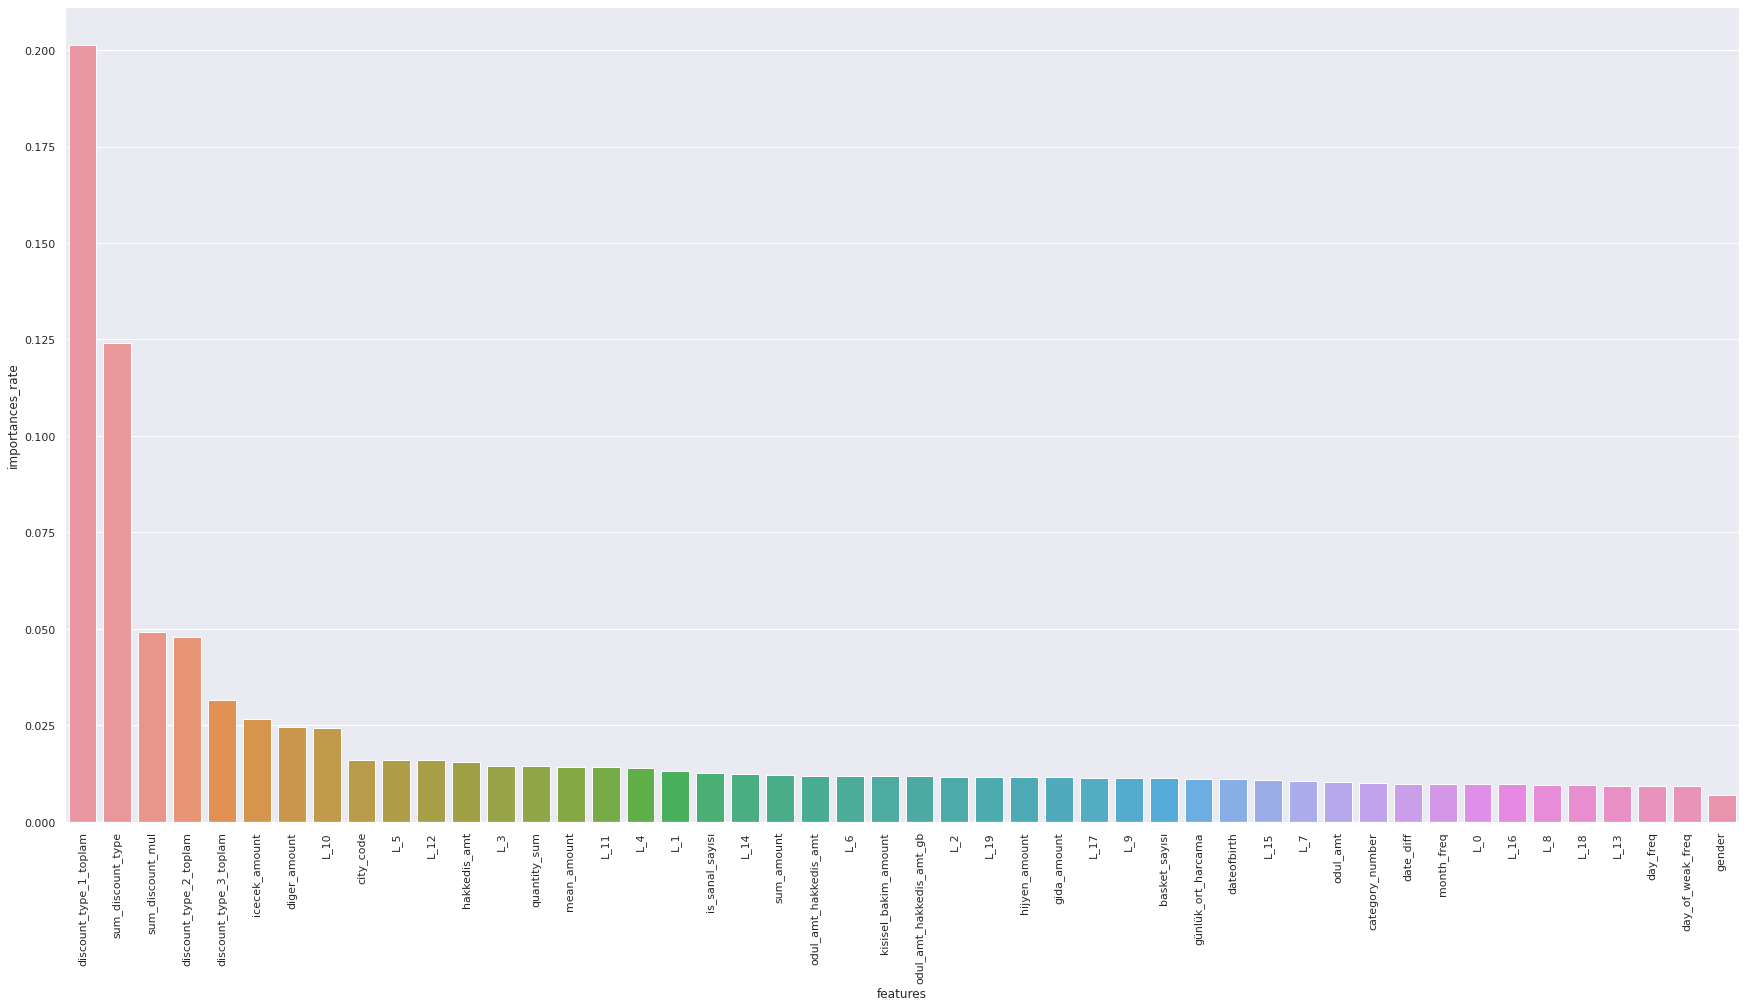

In [35]:
importances=pd.DataFrame([model.feature_importances_ for model in all_models]).mean(axis=0).values
dum=pd.DataFrame(data={'features':data_test.columns,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
#dum.features=dum.features.map(lambda x:  '_'.join(x) if type(x)==tuple else x)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(x=dum.features,y=dum.importances_rate)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [36]:
submission=test_id.to_frame()
submission['response']=pred
sample_submission=pd.read_csv('/kaggle/input/migros-datathon-coderspace/sample_submission.csv')
sample_submission=sample_submission[['individualnumber']].merge(submission,how='left',on='individualnumber').fillna(0)
sample_submission.response=sample_submission.response.astype(int)
sample_submission.set_index('individualnumber',drop=True,inplace=True)
sample_submission.to_csv('./migros_45.csv')

In [39]:
sample_submission

,response
individualnumber,
95812936,0
23929570,0
95948115,0
100898513,0
12769156,1
...,...
93418529,0
97397069,0
95212479,0


In [ ]:
conclude 
this competition aims to catch customer that back return any response to campaings 